# 1. Import libraries

In [967]:
import os
import path
import math
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from haversine import haversine, Unit
from datetime import datetime
from pandas import Timestamp
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

# 2. Input data

### 1. Merge all small files to form a big file. Also add a feature (cab_no) that help distinguish one cab data from other.

In [2]:
# List of cab data files
cabFiles = os.listdir("cabspottingdata")

# This will help in distinguishing data from different cabs
cabNumber = 1

# Open output file in write mode
with open("allData.txt", "w") as outfile:
    # Iterate through list
    for cabFile in cabFiles:
        # Open each file in read mode
        with open("cabspottingdata/" + cabFile, "r") as infile:
            # Data from a file
            lines = infile.read().splitlines()
            # Add the cab number to the file data
            new_lines = [str(cabNumber) + " " + line.strip() for line in lines]
            # Write the file data to a output file
            outfile.write("\n".join(new_lines))

        # Increment the cab number
        cabNumber = cabNumber + 1

### 2. Read data from the big merged file into a dataframe

In [3]:
# Read the data, no header, with space as separator and ignore errors from wrong data
cab_data = pd.read_csv(
    "allData.txt", error_bad_lines=False, warn_bad_lines=False, sep=" ", header=None
)

# Assign column names
cab_data.columns = ["cab_no", "latitude", "longitude", "occupancy", "unix_time"]

# Convert Unix time to datatimestamp
cab_data["date_time"] = pd.to_datetime(cab_data["unix_time"], unit="s")

In [4]:
cab_data.head()

,cab_no,latitude,longitude,occupancy,unix_time,date_time
0,1,37.75153,-122.39447,0,1211033530,2008-05-17 14:12:10
1,1,37.75149,-122.39447,0,1211033614,2008-05-17 14:13:34
2,1,37.75149,-122.39447,0,1211033674,2008-05-17 14:14:34
3,1,37.75149,-122.39446,0,1211033735,2008-05-17 14:15:35
4,1,37.75144,-122.39449,0,1211035303,2008-05-17 14:41:43


# 2. The potential for yearly reduction on CO2 emissions

## 2.1 Feature engineering

### 1. Create a dataframe with rides or journeys with and without passengers

In order to determine the potential of CO2 emissions caused by taxi cabs roaming without passengers, we have to know when the cabs were with passengers and when without. So let's trasform the taxi sensor data to get taxi rides data.

In [5]:
column_names = [
    "cab_no",
    "startLatitude",
    "endLatitude",
    "startLongitude",
    "endLongitude",
    "startTime",
    "endTime",
    "occupancy",
]
cab_data_rides = pd.DataFrame(columns=column_names)

In [6]:
cab_nos = cab_data["cab_no"].unique()

for cab_no in cab_nos:
    single_cab_data = cab_data[cab_data.cab_no == cab_no].sort_values(
        by=["cab_no", "date_time"]
    )

    occupancy, startLatitude, endLatitude, startLongitude, endLongitude, startTime, endTime = (
        None,
        None,
        None,
        None,
        None,
        None,
        None,
    )

    print("processing data for a new cab - cab no = ", cab_no)
    for index, row in single_cab_data.iterrows():
        if occupancy == None:
            print("First record - cab no = ", cab_no)
            # For the first record of a cab, assign the start point and end point of the ride
            startLatitude, startLongitude, occupancy, startTime = (
                row["latitude"],
                row["longitude"],
                row["occupancy"],
                row["date_time"],
            )
            endLatitude, endLongitude, endTime = (
                row["latitude"],
                row["longitude"],
                row["date_time"],
            )

        elif occupancy == row["occupancy"]:
            # if the occupancy is same as that of the previous record, just update the end points of the ride
            endLatitude, endLongitude, endTime = (
                row["latitude"],
                row["longitude"],
                row["date_time"],
            )

        elif occupancy != row["occupancy"]:
            # Change in occupancy means that the ride status has changed i.e. previous ride has ended.
            endLatitude, endLongitude, endTime = (
                row["latitude"],
                row["longitude"],
                row["date_time"],
            )

            # if the occupancy is different from that of the previous record, then insert the previous ride data into the dataframe
            df = {
                "cab_no": row["cab_no"],
                "startLatitude": startLatitude,
                "endLatitude": endLatitude,
                "startLongitude": startLongitude,
                "endLongitude": endLongitude,
                "startTime": startTime,
                "endTime": endTime,
                "occupancy": occupancy,
            }
            cab_data_rides = cab_data_rides.append(df, ignore_index=True)

            # then assign the start point and end point (already done in first step) of a different ride.
            startLatitude, startLongitude, occupancy, startTime = (
                row["latitude"],
                row["longitude"],
                row["occupancy"],
                row["date_time"],
            )

    # Insert final ride data
    df = {
        "cab_no": row["cab_no"],
        "startLatitude": startLatitude,
        "endLatitude": endLatitude,
        "startLongitude": startLongitude,
        "endLongitude": endLongitude,
        "startTime": startTime,
        "endTime": endTime,
        "occupancy": occupancy,
    }
    cab_data_rides = cab_data_rides.append(df, ignore_index=True)

processing data for a new cab - cab no =  1
First record - cab no =  1
processing data for a new cab - cab no =  2
First record - cab no =  2
processing data for a new cab - cab no =  3
First record - cab no =  3
processing data for a new cab - cab no =  4
First record - cab no =  4
processing data for a new cab - cab no =  5
First record - cab no =  5
processing data for a new cab - cab no =  6
First record - cab no =  6
processing data for a new cab - cab no =  7
First record - cab no =  7
processing data for a new cab - cab no =  8
First record - cab no =  8
processing data for a new cab - cab no =  9
First record - cab no =  9
processing data for a new cab - cab no =  10
First record - cab no =  10
processing data for a new cab - cab no =  11
First record - cab no =  11
processing data for a new cab - cab no =  12
First record - cab no =  12
processing data for a new cab - cab no =  13
First record - cab no =  13
processing data for a new cab - cab no =  14
First record - cab no = 

processing data for a new cab - cab no =  114
First record - cab no =  114
processing data for a new cab - cab no =  115
First record - cab no =  115
processing data for a new cab - cab no =  116
First record - cab no =  116
processing data for a new cab - cab no =  117
First record - cab no =  117
processing data for a new cab - cab no =  118
First record - cab no =  118
processing data for a new cab - cab no =  119
First record - cab no =  119
processing data for a new cab - cab no =  120
First record - cab no =  120
processing data for a new cab - cab no =  121
First record - cab no =  121
processing data for a new cab - cab no =  122
First record - cab no =  122
processing data for a new cab - cab no =  123
First record - cab no =  123
processing data for a new cab - cab no =  124
First record - cab no =  124
processing data for a new cab - cab no =  125
First record - cab no =  125
processing data for a new cab - cab no =  126
First record - cab no =  126
processing data for a new

processing data for a new cab - cab no =  224
First record - cab no =  224
processing data for a new cab - cab no =  225
First record - cab no =  225
processing data for a new cab - cab no =  226
First record - cab no =  226
processing data for a new cab - cab no =  227
First record - cab no =  227
processing data for a new cab - cab no =  228
First record - cab no =  228
processing data for a new cab - cab no =  229
First record - cab no =  229
processing data for a new cab - cab no =  230
First record - cab no =  230
processing data for a new cab - cab no =  231
First record - cab no =  231
processing data for a new cab - cab no =  232
First record - cab no =  232
processing data for a new cab - cab no =  233
First record - cab no =  233
processing data for a new cab - cab no =  234
First record - cab no =  234
processing data for a new cab - cab no =  235
First record - cab no =  235
processing data for a new cab - cab no =  236
First record - cab no =  236
processing data for a new

processing data for a new cab - cab no =  334
First record - cab no =  334
processing data for a new cab - cab no =  335
First record - cab no =  335
processing data for a new cab - cab no =  336
First record - cab no =  336
processing data for a new cab - cab no =  337
First record - cab no =  337
processing data for a new cab - cab no =  338
First record - cab no =  338
processing data for a new cab - cab no =  339
First record - cab no =  339
processing data for a new cab - cab no =  340
First record - cab no =  340
processing data for a new cab - cab no =  341
First record - cab no =  341
processing data for a new cab - cab no =  342
First record - cab no =  342
processing data for a new cab - cab no =  343
First record - cab no =  343
processing data for a new cab - cab no =  344
First record - cab no =  344
processing data for a new cab - cab no =  345
First record - cab no =  345
processing data for a new cab - cab no =  346
First record - cab no =  346
processing data for a new

processing data for a new cab - cab no =  444
First record - cab no =  444
processing data for a new cab - cab no =  445
First record - cab no =  445
processing data for a new cab - cab no =  446
First record - cab no =  446
processing data for a new cab - cab no =  447
First record - cab no =  447
processing data for a new cab - cab no =  448
First record - cab no =  448
processing data for a new cab - cab no =  449
First record - cab no =  449
processing data for a new cab - cab no =  450
First record - cab no =  450
processing data for a new cab - cab no =  451
First record - cab no =  451
processing data for a new cab - cab no =  452
First record - cab no =  452
processing data for a new cab - cab no =  453
First record - cab no =  453
processing data for a new cab - cab no =  454
First record - cab no =  454
processing data for a new cab - cab no =  455
First record - cab no =  455
processing data for a new cab - cab no =  456
First record - cab no =  456
processing data for a new

**Save the data in a CSV file to avoid reprocessing in future.**

In [980]:
cab_data_rides.to_csv("cab_data_rides.csv", index=False)

In [283]:
#cab_data_rides = pd.read_csv("cab_data_rides.csv", parse_dates=["startTime", "endTime"])

In [981]:
cab_data_rides.head(2)

,cab_no,startLatitude,endLatitude,startLongitude,endLongitude,startTime,endTime,occupancy,trip_distance_miles,trip_duration_minutes,speed_miles_per_hour,day_of_week,isWeekend,phase_of_day
0,1,37.75153,37.74977,-122.39447,-122.39724,2008-05-17 14:12:10,2008-05-17 14:51:10,0,0.19,39.00,0.29,Saturday,1,Afternoon
1,1,37.74977,37.75580,-122.39724,-122.41441,2008-05-17 14:51:10,2008-05-17 14:56:00,1,1.03,4.83,12.80,Saturday,1,Afternoon


### 2. Create a new feature for 'trip distance' (straight line) during the start and end coordinates.

In order to determine the potential of CO2 emissions caused by taxi cabs roaming without passengers, we have to find the distance travelled by cabs when without passengers.

In [285]:
# Calculate trip distance in miles
def calculateDistance(cab_data_ride):
    return round(
        haversine(
            (cab_data_ride.startLatitude, cab_data_ride.startLongitude),
            (cab_data_ride.endLatitude, cab_data_ride.endLongitude),
            unit=Unit.MILES,
        ),
        2,
    )


cab_data_rides["trip_distance_miles"] = cab_data_rides.apply(calculateDistance, axis=1)

## 2.2 EDA

### 1. Analyze the 'trip distance'

Let's analyze the trip distance for the rides where cab is unoccupied with customers.

In [286]:
cab_data_rides[cab_data_rides.occupancy == 0].trip_distance_miles.isnull().sum()

0

So there is no empty values in the trip distance field.

In [287]:
(cab_data_rides[cab_data_rides.occupancy == 0].trip_distance_miles == 0).sum()

23480

The trip distance when a cab is unoccupied can be zero. After dropping a passenger at a place, the cab can stand there until it finds a new passenger.

Let's analyze the distributioon of trip distances for unoccupied trips to find extreme outliers (impossible).

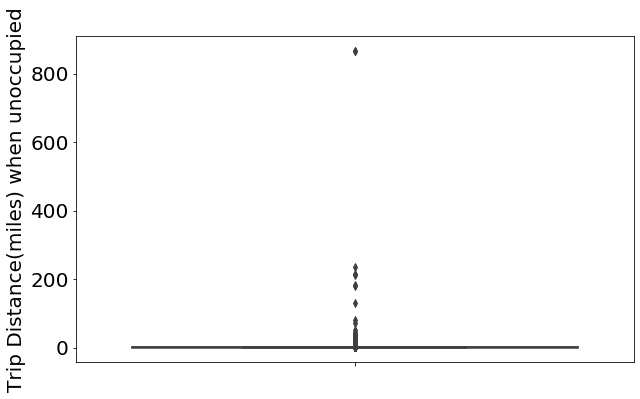

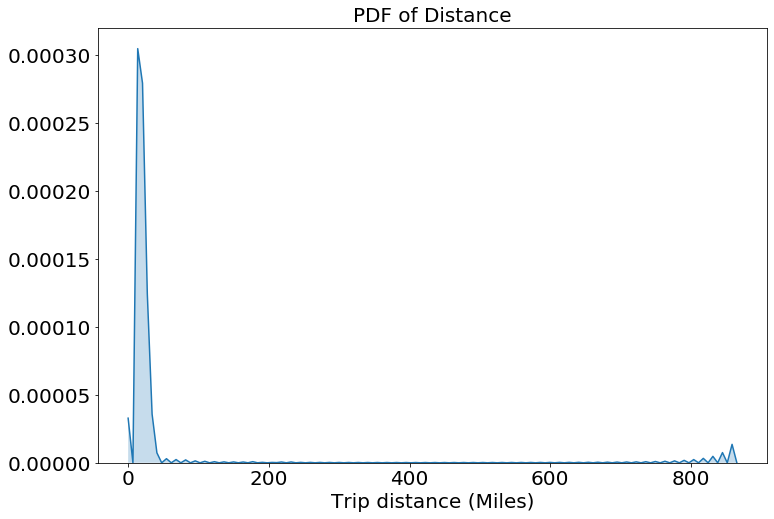

In [288]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    "trip_distance_miles",
    data=cab_data_rides[cab_data_rides.occupancy == 0],
    orient="v",
)
plt.tick_params(labelsize=20)
plt.ylabel("Trip Distance(miles) when unoccupied", fontsize=20)
plt.show()

plt.figure(figsize=(12, 8))
sns.kdeplot(
    cab_data_rides[cab_data_rides.occupancy == 0].trip_distance_miles.values,
    shade=True,
    cumulative=False,
)
plt.tick_params(labelsize=20)
plt.xlabel("Trip distance (Miles)", fontsize=20)
plt.title("PDF of Distance", fontsize=20)
plt.show()

In [289]:
quantile_trip_distance_miles = cab_data_rides[
    cab_data_rides.occupancy == 0
].trip_distance_miles.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print(
        "{}th percentile value of Trip Distance is {}miles".format(
            (int(i * 100)), quantile_trip_distance_miles[i]
        )
    )

print("###############################")
qValues = np.round(np.arange(0.90, 1.01, 0.01), 2)
for i in qValues:
    print(
        "{}th percentile value of Trip Distance is {}miles".format(
            (int(i * 100)), quantile_trip_distance_miles[i]
        )
    )

print("###############################")
qValues = np.round(np.arange(0.991, 1.001, 0.001), 4)
quantile_trip_distance_miles = cab_data_rides[
    cab_data_rides.occupancy == 0
].trip_distance_miles.quantile(qValues)
for i in qValues:
    print(
        "{}th percentile value of Trip Distance is {}miles".format(
            (i * 100), quantile_trip_distance_miles[i]
        )
    )

0th percentile value of Trip Distance is 0.0miles
10th percentile value of Trip Distance is 0.03miles
20th percentile value of Trip Distance is 0.12miles
30th percentile value of Trip Distance is 0.24miles
40th percentile value of Trip Distance is 0.37miles
50th percentile value of Trip Distance is 0.53miles
60th percentile value of Trip Distance is 0.74miles
70th percentile value of Trip Distance is 1.04miles
80th percentile value of Trip Distance is 1.57miles
90th percentile value of Trip Distance is 3.26miles
100th percentile value of Trip Distance is 865.37miles
###############################
90th percentile value of Trip Distance is 3.26miles
91th percentile value of Trip Distance is 3.79miles
92th percentile value of Trip Distance is 4.74miles
93th percentile value of Trip Distance is 6.75miles
94th percentile value of Trip Distance is 8.58miles
95th percentile value of Trip Distance is 9.73miles
96th percentile value of Trip Distance is 10.8miles
97th percentile value of Trip D

<b>Observations:</b>Till 99.9th percentile, value of trip distance when the cabs were unoccupied is (25.05 miles). On 100th percentile values are huge deviation, with a trip distance of 865.37 miles. However, the trip of that long distance is quite possible.

Afterall this challenge-1 is all about a simple calculation. We are not going to creating any ML model, which are usually influenced by outliers. So we don't need to handle outliers in this challenge.

## 2.3 Final calculation

### 1. Calculate total distance travelled when the cabs were not occupied.

In [290]:
# Total distance covered by each cab when unoccupied
distance_unoccupied_cab = (
    cab_data_rides[cab_data_rides.occupancy == 0]
    .groupby(["cab_no"])
    .agg({"trip_distance_miles": "sum"})
)
distance_unoccupied_cab.reset_index(inplace=True)

# Number of days of cab data
no_of_days = (cab_data.date_time.max() - cab_data.date_time.min()).days

# Average distance covered by a cab when unoccupied (in miles/month per cab)
avg_dist_unoccupied_cab_month = (
    round(distance_unoccupied_cab.trip_distance_miles.mean(), 2) / no_of_days * 30
)

print("Number of days for which data is available = ", no_of_days)
print(
    "Average distance (miles) covered by each taxi cab in a month while unoccupied = ",
    avg_dist_unoccupied_cab_month,
)

Number of days for which data is available =  23
Average distance (miles) covered by each taxi cab in a month while unoccupied =  1715.9478260869564


### 2. Calculate total co2 emissions, caused by cabs roaming without passengers.

In [291]:
# CO2 emission per mile (in grams/mile)
co2_emissions_mile = 404

# Number of cabs
no_of_cabs = cab_data_rides.cab_no.unique().size

# CO2 emissions from all taxis in a year because of distance travelled when unoccupied (in grams)
co2_emissions_year = round(
    no_of_cabs * avg_dist_unoccupied_cab_month * co2_emissions_mile * 12, 2
)

### 3. Calculate total co2 emissions, caused by cabs roaming without passengers, taking into consideration the change in cab fleet.

In [292]:
# taxi cab fleet is changing at the rate of 10% per month (from combustion enginepowered vehicles to electric vehicles)
cab_fleet_change_rate = 0.1

# CO2 emissions from all taxis in a year because of distance travelled when unoccupied (in grams) considering change in fleet
co2_emissions_year_change_cab_fleet = 0

# Changed taxi numbers considering the change in fleet
changed_no_of_cabs = no_of_cabs

for month in range(1, 13):
    changed_no_of_cabs = changed_no_of_cabs * (1 - cab_fleet_change_rate)
    co2_emissions_month_change_cab_fleet = round(
        changed_no_of_cabs * avg_dist_unoccupied_cab_month * co2_emissions_mile, 2
    )
    co2_emissions_year_change_cab_fleet = round(
        co2_emissions_year_change_cab_fleet + co2_emissions_month_change_cab_fleet, 2
    )

print(
    "Expected CO2 emmisions (grams) in next year from all taxis while unoccupied (no fleet change) = ",
    co2_emissions_year,
)
print(
    "Expected CO2 emmisions (grams) in next year from all taxis while unoccupied (10% fleet change) = ",
    co2_emissions_year_change_cab_fleet,
)

co2_emissions_reduction_percentage = round(
    (co2_emissions_year - co2_emissions_year_change_cab_fleet)
    / co2_emissions_year
    * 100
)
print(
    "Expected CO2 emissions reduction with change in cab fleet (%) = ",
    co2_emissions_reduction_percentage,
)

Expected CO2 emmisions (grams) in next year from all taxis while unoccupied (no fleet change) =  4467257387.69
Expected CO2 emmisions (grams) in next year from all taxis while unoccupied (10% fleet change) =  2404178965.74
Expected CO2 emissions reduction with change in cab fleet (%) =  46


# 3. Identify clusters of taxi cabs

There is always a goal/reason behind a user group segmentation process. As we aren't given one, let's make one. Based on this goal, we will do feature engineering, transformation, data cleaning and modeling.

Segmentation goal:
We want to create a reward, awareness and penalty program for all the taxi drivers based on their driving behaviour.
When a taxi driver does well, we will reward him/her. When the driver doesn't do well, we will give him/her a penalty point and give him awareness training. When a taxi driver is neither doing good or bad, we just give them awareness training to improve his/her driving behaviour.

In [293]:
cab_data_rides.head()

,cab_no,startLatitude,endLatitude,startLongitude,endLongitude,startTime,endTime,occupancy,trip_distance_miles
0,1,37.75153,37.74977,-122.39447,-122.39724,2008-05-17 14:12:10,2008-05-17 14:51:10,0,0.19
1,1,37.74977,37.75580,-122.39724,-122.41441,2008-05-17 14:51:10,2008-05-17 14:56:00,1,1.03
2,1,37.75580,37.75053,-122.41441,-122.42086,2008-05-17 14:56:00,2008-05-17 15:18:06,0,0.51
3,1,37.75053,37.75177,-122.42086,-122.43095,2008-05-17 15:18:06,2008-05-17 15:21:50,1,0.56
4,1,37.75177,37.77173,-122.43095,-122.41838,2008-05-17 15:21:50,2008-05-17 15:43:51,0,1.54


## 3.1 Feature engineering (Creating new features)

Before we do a EDA and data cleaning, let's do so simple feature engineering on Ride data available. These new data will help us during the EDA and data cleaning.

### 3.1.1 TRIP DURATION in minutes using startTime and endTime of the trip

In [294]:
# Trip duration in minutes
def calculateTimeDifference(cab_data_ride):
    return round((cab_data_ride.endTime - cab_data_ride.startTime).seconds / 60, 2)


cab_data_rides["trip_duration_minutes"] = cab_data_rides.apply(
    calculateTimeDifference, axis=1
)

### 3.1.2 TRIP SPEED using the distance and time of the trip.

In [295]:
cab_data_rides["speed_miles_per_hour"] = round(
    cab_data_rides["trip_distance_miles"]
    / (cab_data_rides["trip_duration_minutes"] / 60),
    2,
)

### 3.1.3 DAY OF THE WEEK using the trip start time.

In [296]:
day_name = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]


def calculateDayOfWeek(cab_data_ride):
    return day_name[cab_data_ride.startTime.dayofweek]


cab_data_rides["day_of_week"] = cab_data_rides.apply(calculateDayOfWeek, axis=1)

### 3.1.4 IS TRIP ON WEEKEND using the day of the week of the trip.

In [297]:
def checkIfWeekend(cab_data_ride):
    if cab_data_ride.day_of_week in ["Saturday", "Sunday"]:
        return 1
    else:
        return 0


cab_data_rides["isWeekend"] = cab_data_rides.apply(checkIfWeekend, axis=1)

### 3.1.5 PHASE OF THE DAY using the hour of the trip time.

In [298]:
def calculatePhaseOfDay(cab_data_ride):
    if 5 <= cab_data_ride.startTime.hour <= 11:
        return "Morning"
    elif 12 <= cab_data_ride.startTime.hour <= 16:
        return "Afternoon"
    elif 17 <= cab_data_ride.startTime.hour <= 20:
        return "Evening"
    else:
        return "night"


cab_data_rides["phase_of_day"] = cab_data_rides.apply(calculatePhaseOfDay, axis=1)

In [299]:
cab_data_rides.head(2)

,cab_no,startLatitude,endLatitude,startLongitude,endLongitude,startTime,endTime,occupancy,trip_distance_miles,trip_duration_minutes,speed_miles_per_hour,day_of_week,isWeekend,phase_of_day
0,1,37.75153,37.74977,-122.39447,-122.39724,2008-05-17 14:12:10,2008-05-17 14:51:10,0,0.19,39.00,0.29,Saturday,1,Afternoon
1,1,37.74977,37.75580,-122.39724,-122.41441,2008-05-17 14:51:10,2008-05-17 14:56:00,1,1.03,4.83,12.80,Saturday,1,Afternoon


## 3.2 Data cleaning

### 3.2.1 NULL check and handle

In [300]:
cab_data_rides.isnull().sum()

cab_no                    0
startLatitude             0
endLatitude               0
startLongitude            0
endLongitude              0
startTime                 0
endTime                   0
occupancy                 0
trip_distance_miles       0
trip_duration_minutes     0
speed_miles_per_hour     28
day_of_week               0
isWeekend                 0
phase_of_day              0
dtype: int64

There are 28 records where the speed_miles_per_hour is null or not available. Let's see those records.

In [302]:
cab_data_rides[cab_data_rides.speed_miles_per_hour.isnull()].head(2)

,cab_no,startLatitude,endLatitude,startLongitude,endLongitude,startTime,endTime,occupancy,trip_distance_miles,trip_duration_minutes,speed_miles_per_hour,day_of_week,isWeekend,phase_of_day
5800,4,37.76127,37.76127,-122.39841,-122.39841,2008-06-10 09:06:16,2008-06-10 09:06:16,0,0.0,0.0,NaN,Tuesday,0,Morning
14586,9,37.78666,37.78666,-122.39856,-122.39856,2008-06-09 18:02:50,2008-06-09 18:02:50,0,0.0,0.0,NaN,Monday,0,Evening


There records corresponds to the trips with a 
1. Trip duration of zero minute i.e. trip start time = trip end time. 
2. Trip start coordinates are same as trip end coordinates. This means circular trips.

These is error data, hence can be removed.

In [303]:
cab_data_rides_clean = cab_data_rides.copy()
cab_data_rides_clean.drop(
    cab_data_rides_clean[cab_data_rides_clean.speed_miles_per_hour.isnull()].index,
    inplace=True,
)

In [304]:
cab_data_rides_clean.speed_miles_per_hour.isnull().sum()

0

### 3.2.2. Handle invalid values

**TRIP START POINT and TRIP END POINT**

Let's see if there are any trips with same start longitude-latitude and end longitude-latidue can't be same. Such trips are possible, and occurs in case of circular rides. As the distance of the ride can't be accurately calculated, so we can get ride of such records.

In [305]:
(
    (cab_data_rides_clean.startLongitude == cab_data_rides_clean.endLongitude)
    & (cab_data_rides_clean.startLatitude == cab_data_rides_clean.endLatitude)
).sum()

6831

There are 6831 trips which have same pickup and dropoff points.

In [306]:
cab_data_rides_clean.drop(
    cab_data_rides_clean[
        (
            (cab_data_rides_clean.startLongitude == cab_data_rides_clean.endLongitude)
            & (cab_data_rides_clean.startLatitude == cab_data_rides_clean.endLatitude)
        )
    ].index,
    inplace=True,
)

In [307]:
(
    (cab_data_rides_clean.startLongitude == cab_data_rides_clean.endLongitude)
    & (cab_data_rides_clean.startLatitude == cab_data_rides_clean.endLatitude)
).sum()

0

**TRIP START TIME and TRIP END TIME**

The trip start time and end time can't be same. Let's see if there are any such trips. If there are any, we can remove such records.

In [308]:
(cab_data_rides_clean.startTime == cab_data_rides_clean.endTime).sum()

0

**TRIP DISTANCE**

In [309]:
(cab_data_rides_clean.trip_distance_miles == 0).sum()

21775

In [310]:
cab_data_rides_clean[cab_data_rides_clean.trip_distance_miles == 0].head(2)

,cab_no,startLatitude,endLatitude,startLongitude,endLongitude,startTime,endTime,occupancy,trip_distance_miles,trip_duration_minutes,speed_miles_per_hour,day_of_week,isWeekend,phase_of_day
23,1,37.77697,37.77697,-122.39523,-122.39521,2008-05-17 19:22:22,2008-05-17 19:22:32,1,0.0,0.17,0.0,Saturday,1,Evening
30,1,37.80679,37.80682,-122.40576,-122.40583,2008-05-17 20:22:17,2008-05-17 20:22:22,0,0.0,0.08,0.0,Saturday,1,Evening


After looking at the data, it is quite evident that these rides have start and end coordinates that differ on 4th decimal. This causes the distance to be zero. We can remove these trips to prevent any data biases.

In [311]:
cab_data_rides_clean.drop(
    cab_data_rides_clean[cab_data_rides_clean.trip_distance_miles == 0].index,
    inplace=True,
)

In [312]:
(cab_data_rides_clean.trip_distance_miles == 0).sum()

0

**TRIP DURATION**

There should be no trips with zero trip duration. If there are any, we should remove those.

In [313]:
(cab_data_rides_clean.trip_duration_minutes == 0).sum()

0

**TRIP SPEED**

There should be no trips with zero trip speed. If there are any, we should remove those.

In [314]:
(cab_data_rides_clean.speed_miles_per_hour == 0).sum()

22

In [315]:
cab_data_rides_clean.drop(cab_data_rides_clean[cab_data_rides_clean.speed_miles_per_hour == 0].index, inplace=True)

In [316]:
(cab_data_rides_clean.speed_miles_per_hour == 0).sum()

0

### 3.2.3 Handle outliers

**TRIP DURATION**

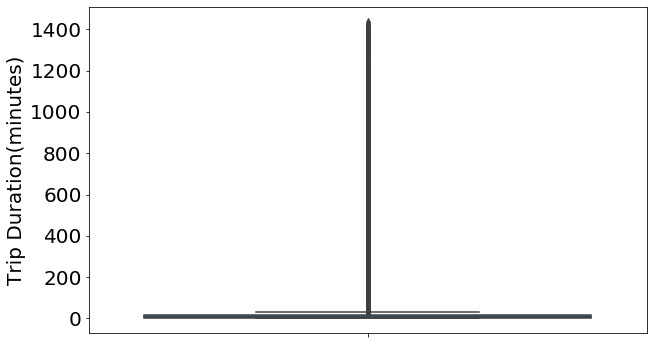

In [317]:
plt.figure(figsize=(10, 6))
sns.boxplot("trip_duration_minutes", data=cab_data_rides_clean, orient="v")
plt.tick_params(labelsize=20)
plt.ylabel("Trip Duration(minutes)", fontsize=20)
plt.show()

In [318]:
quantile_trip_duration_minutes = cab_data_rides_clean.trip_duration_minutes.quantile(
    np.round(np.arange(0.00, 1.01, 0.01), 2)
)
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print(
        "{}th percentile value of Trip Duration is {} min".format(
            (int(i * 100)), quantile_trip_duration_minutes[i]
        )
    )

print("###############################")
qValues = np.round(np.arange(0.90, 1.01, 0.01), 2)
for i in qValues:
    print(
        "{}th percentile value of Trip Duration is {} min".format(
            (int(i * 100)), quantile_trip_duration_minutes[i]
        )
    )

0th percentile value of Trip Duration is 0.02 min
10th percentile value of Trip Duration is 1.85 min
20th percentile value of Trip Duration is 3.67 min
30th percentile value of Trip Duration is 5.200000000000001 min
40th percentile value of Trip Duration is 6.68 min
50th percentile value of Trip Duration is 8.35 min
60th percentile value of Trip Duration is 10.35 min
70th percentile value of Trip Duration is 13.08 min
80th percentile value of Trip Duration is 17.55 min
90th percentile value of Trip Duration is 27.25 min
100th percentile value of Trip Duration is 1435.15 min
###############################
90th percentile value of Trip Duration is 27.25 min
91th percentile value of Trip Duration is 29.42 min
92th percentile value of Trip Duration is 32.2 min
93th percentile value of Trip Duration is 36.03 min
94th percentile value of Trip Duration is 41.37 min
95th percentile value of Trip Duration is 49.17 min
96th percentile value of Trip Duration is 60.77000000000001 min
97th percent

<b>Observations:</b>Till 99th percentile value of trip duration (235 min or approx 4 hours), everything looks legit. On 100th percentile values are huge deviation, with a trip duration of 1435 mins or 24 hours.

Let's assume that for the safety of both driver and rider, the maximum allowed single trip duration is 4 hours i.e 240 mins.

Based on this, let's remove these outliers.

In [319]:
prev_count = cab_data_rides_clean.shape[0]
cab_data_rides_clean.drop(
    cab_data_rides_clean[cab_data_rides_clean.trip_duration_minutes > 240].index,
    inplace=True,
)

print("No of records removed = ", prev_count - cab_data_rides_clean.shape[0])

No of records removed =  8824


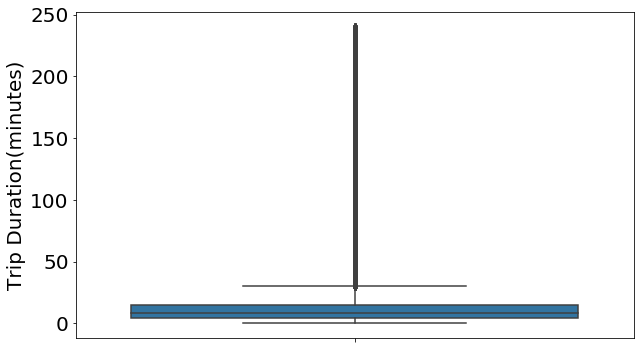

In [320]:
plt.figure(figsize=(10, 6))
sns.boxplot("trip_duration_minutes", data=cab_data_rides_clean, orient="v")
plt.tick_params(labelsize=20)
plt.ylabel("Trip Duration(minutes)", fontsize=20)
plt.show()

Let's see the distribution of trip duration.

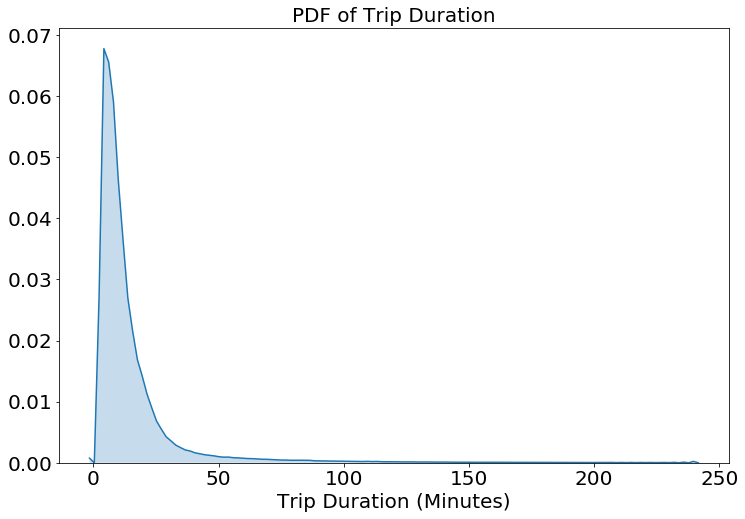

In [321]:
plt.figure(figsize=(12, 8))
sns.kdeplot(
    cab_data_rides_clean.trip_duration_minutes.values, shade=True, cumulative=False
)
plt.tick_params(labelsize=20)
plt.xlabel("Trip Duration (Minutes)", fontsize=20)
plt.title("PDF of Trip Duration", fontsize=20)
plt.show()

**TRIP SPEED**

In [322]:
def changingLabels(num):
    if num < 10 ** 3:
        return num
    elif num >= 10 ** 3 and num < 10 ** 6:
        return str(num / 10 ** 3) + "k"
    elif num >= 10 ** 6 and num < 10 ** 9:
        return str(num / 10 ** 6) + "M"
    else:
        return str(num / 10 ** 9) + "B"

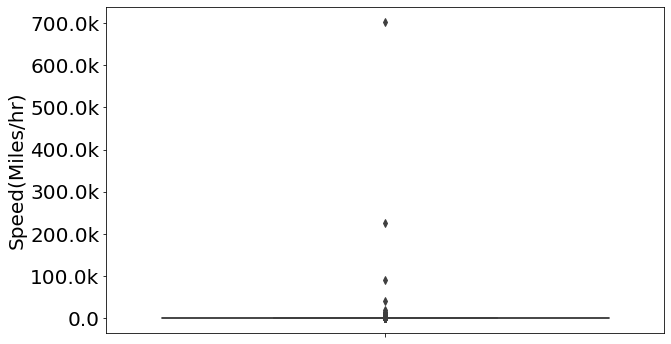

In [323]:
fig = plt.figure(figsize=(10, 6))
ax = sns.boxplot("speed_miles_per_hour", data=cab_data_rides_clean, orient="v")

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
plt.tick_params(labelsize=20)
plt.ylabel("Speed(Miles/hr)", fontsize=20)
plt.show()

In [324]:
quantile_speed = cab_data_rides_clean.speed_miles_per_hour.quantile(
    np.round(np.arange(0.00, 1.01, 0.01), 2)
)

qValues = np.round(np.arange(0.00, 1.01, 0.1), 4)
for i in qValues:
    print(
        "{}th percentile value of speed is {} miles/hr".format(
            int(i * 100), quantile_speed[i]
        )
    )

print("###############################")
qValues = np.round(np.arange(0.91, 1.01, 0.01), 3)
for i in qValues:
    print(
        "{}th percentile value of speed is {} miles/hr".format(
            int(i * 100), quantile_speed[i]
        )
    )

print("###############################")
qValues = np.round(np.arange(0.991, 1.001, 0.001), 4)
quantile_speed = cab_data_rides_clean.speed_miles_per_hour.quantile(qValues)
for i in qValues:
    print(
        "{}th percentile value of speed is {} miles/hr".format(
            (i * 100), quantile_speed[i]
        )
    )

0th percentile value of speed is 0.01 miles/hr
10th percentile value of speed is 2.18 miles/hr
20th percentile value of speed is 4.04 miles/hr
30th percentile value of speed is 5.65 miles/hr
40th percentile value of speed is 7.05 miles/hr
50th percentile value of speed is 8.33 miles/hr
60th percentile value of speed is 9.62 miles/hr
70th percentile value of speed is 11.08 miles/hr
80th percentile value of speed is 13.09 miles/hr
90th percentile value of speed is 18.38 miles/hr
100th percentile value of speed is 702330.0 miles/hr
###############################
91th percentile value of speed is 19.97 miles/hr
92th percentile value of speed is 21.77 miles/hr
93th percentile value of speed is 24.409999999999997 miles/hr
94th percentile value of speed is 27.4 miles/hr
95th percentile value of speed is 30.0 miles/hr
96th percentile value of speed is 32.73 miles/hr
97th percentile value of speed is 35.67 miles/hr
98th percentile value of speed is 39.28 miles/hr
99th percentile value of speed

<b>Observations:</b> Here, 100th percentile value of a speed is 41940.0 miles/hr which is BIZZARE. Furthermore, zero speed in a trip is impossible. The 99.6th percentile value of speed is 80 miles/hr, which is possible. 

SF allows a maximum speed of 100 miles/hour for taxi cabs (Assumption). 
So, we are removing all the data points where speed is greater than 100 miles/hr. 

In [325]:
prev_count = cab_data_rides_clean.shape[0]
cab_data_rides_clean.drop(
    cab_data_rides_clean[cab_data_rides_clean.speed_miles_per_hour > 100].index,
    inplace=True,
)

print("No of records removed = ", prev_count - cab_data_rides_clean.shape[0])

No of records removed =  2805


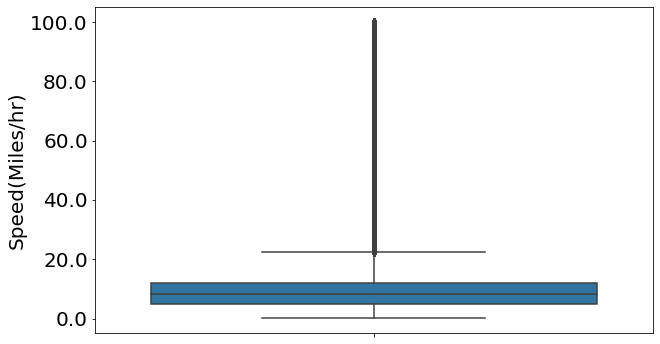

In [326]:
fig = plt.figure(figsize=(10, 6))
ax = sns.boxplot("speed_miles_per_hour", data=cab_data_rides_clean, orient="v")

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
plt.tick_params(labelsize=20)
plt.ylabel("Speed(Miles/hr)", fontsize=20)
plt.show()

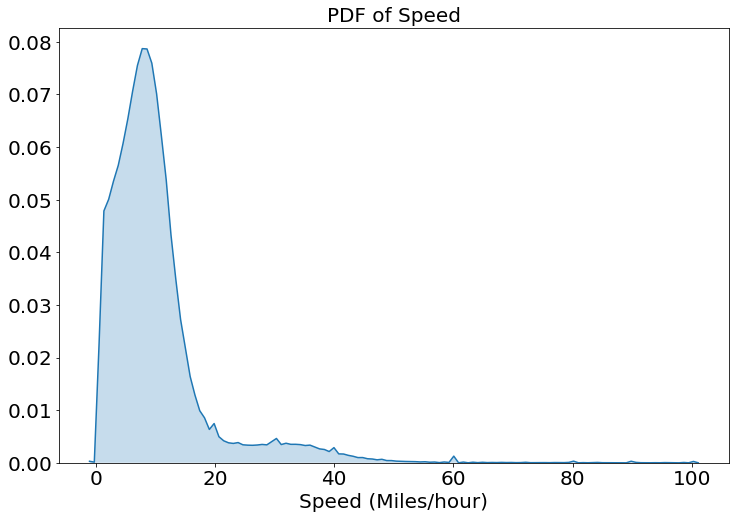

In [327]:
plt.figure(figsize=(12, 8))
sns.kdeplot(
    cab_data_rides_clean.speed_miles_per_hour.values, shade=True, cumulative=False
)
plt.tick_params(labelsize=20)
plt.xlabel("Speed (Miles/hour)", fontsize=20)
plt.title("PDF of Speed", fontsize=20)
plt.show()

In [328]:
print(
    "Average Speed of Taxis around NYC = ",
    round(
        sum(cab_data_rides_clean.speed_miles_per_hour) / cab_data_rides_clean.shape[0],
        2,
    ),
)
print(
    "Distance (miles) covered of Taxis around SF per 10 minutes = "
    + str(
        round(
            sum(cab_data_rides_clean.speed_miles_per_hour)
            / cab_data_rides_clean.shape[0],
            2,
        )
        / 6
    )
    + " per 10 minutes."
)

Average Speed of Taxis around NYC =  10.02
Distance (miles) covered of Taxis around SF per 10 minutes = 1.67 per 10 minutes.


The avg speed in SF is 10 miles/hr, so a cab driver can travel 1.7 miles per 10 min on avg.

**TRIP DISTANCE**

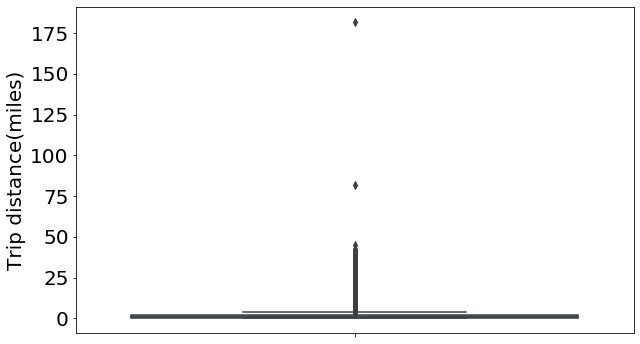

In [329]:
plt.figure(figsize=(10, 6))
sns.boxplot("trip_distance_miles", data=cab_data_rides_clean, orient="v")
plt.tick_params(labelsize=20)
plt.ylabel("Trip distance(miles)", fontsize=20)
plt.show()

In [330]:
quantile_speed = cab_data_rides_clean.trip_distance_miles.quantile(
    np.round(np.arange(0.00, 1.01, 0.01), 2)
)

qValues = np.round(np.arange(0.00, 1.01, 0.1), 4)
for i in qValues:
    print(
        "{}th percentile value of distance is {}miles".format(
            int(i * 100), quantile_speed[i]
        )
    )

print("###############################")
qValues = np.round(np.arange(0.91, 1.01, 0.01), 3)
for i in qValues:
    print(
        "{} percentile value of distance is {}miles".format(
            int(i * 100), quantile_speed[i]
        )
    )

print("###############################")
qValues = np.round(np.arange(0.991, 1.001, 0.001), 4)
quantile_speed = cab_data_rides_clean.trip_distance_miles.quantile(qValues)
for i in qValues:
    print(
        "{} percentile value of distance is {}miles".format(
            (i * 100), quantile_speed[i]
        )
    )

0th percentile value of distance is 0.01miles
10th percentile value of distance is 0.14miles
20th percentile value of distance is 0.34miles
30th percentile value of distance is 0.54miles
40th percentile value of distance is 0.75miles
50th percentile value of distance is 0.99miles
60th percentile value of distance is 1.29miles
70th percentile value of distance is 1.69miles
80th percentile value of distance is 2.35miles
90th percentile value of distance is 4.72miles
100th percentile value of distance is 181.78miles
###############################
91 percentile value of distance is 5.9miles
92 percentile value of distance is 7.99miles
93 percentile value of distance is 9.46miles
94 percentile value of distance is 10.49miles
95 percentile value of distance is 11.23miles
96 percentile value of distance is 11.69miles
97 percentile value of distance is 11.92miles
98 percentile value of distance is 12.239999999999998miles
99 percentile value of distance is 12.89miles
100 percentile value of di

<b>Observations:</b> After removing huge outliers from features such as trip duration and speed, it seems that the outliers for the distance feature have been automatically removed. The distance data in the quantiles looks legit. So, we don't need to remove any outliers.

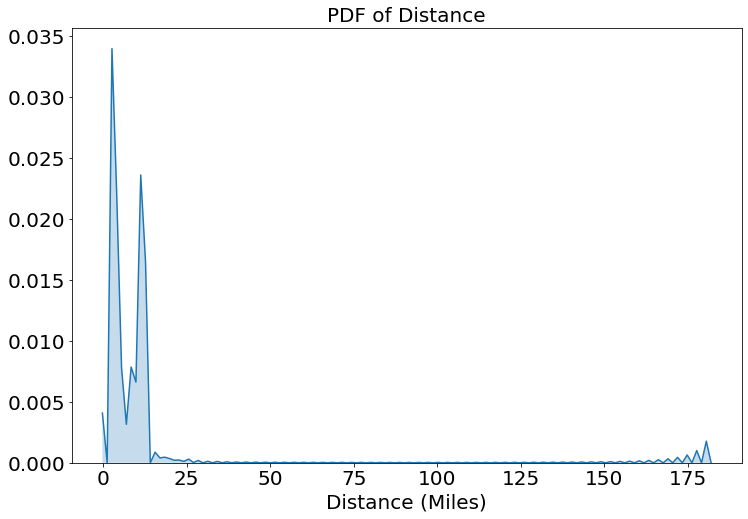

In [331]:
plt.figure(figsize=(12, 8))
sns.kdeplot(
    cab_data_rides_clean.trip_distance_miles.values, shade=True, cumulative=False
)
plt.tick_params(labelsize=20)
plt.xlabel("Distance (Miles)", fontsize=20)
plt.title("PDF of Distance", fontsize=20)
plt.show()

## 3.3 EDA

Let's do multivariate analysis to see corelation between features.

### 3.3.1 OCCUPANCY vs TRIP DISTANCE

Let's see the average distance travelled per trip when the taxi is occupied and when it is unoccupied.

[1.54462351 2.54224195]


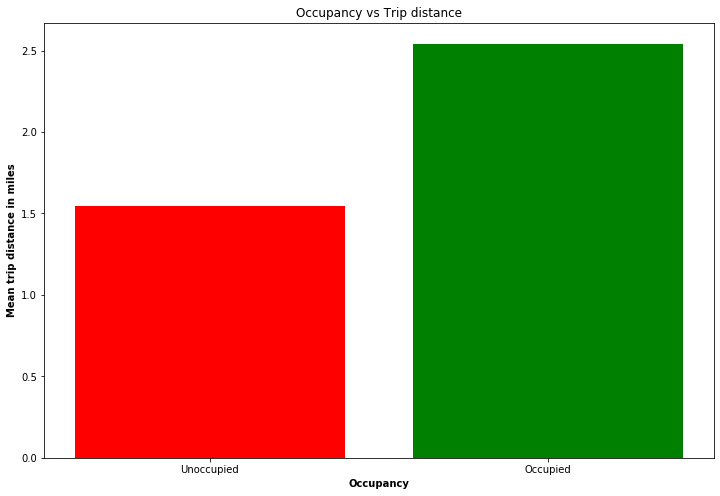

In [332]:
occupancy_distance = cab_data_rides_clean.groupby("occupancy").agg(
    {"trip_distance_miles": "mean"}
)
occupancy_distance.reset_index(inplace=True)
occupancy_distance.rename(
    columns={"trip_distance_miles": "mean_trip_distance_miles"}, inplace=True
)
print(occupancy_distance.mean_trip_distance_miles.values)

# Visualize through Bar plot
plt.figure(figsize=(12, 8))
plt.bar(
    ["Unoccupied", "Occupied"],
    occupancy_distance.mean_trip_distance_miles.values,
    color=("red", "green"),
)
plt.xlabel("Occupancy", fontweight="bold")
plt.ylabel("Mean trip distance in miles", fontweight="bold")
plt.title("Occupancy vs Trip distance")
plt.show()

Average distance travelled by a taxi when occupied is 2.5 miles and when unoccupied is 1.5 miles. This is a nice deviation.

### 3.3.2 OCCUPANCY vs TRIP DURATION

Let's see the average time spent per trip when the taxi is occupied and when it is unoccupied.

[16.57379782 10.87757515]


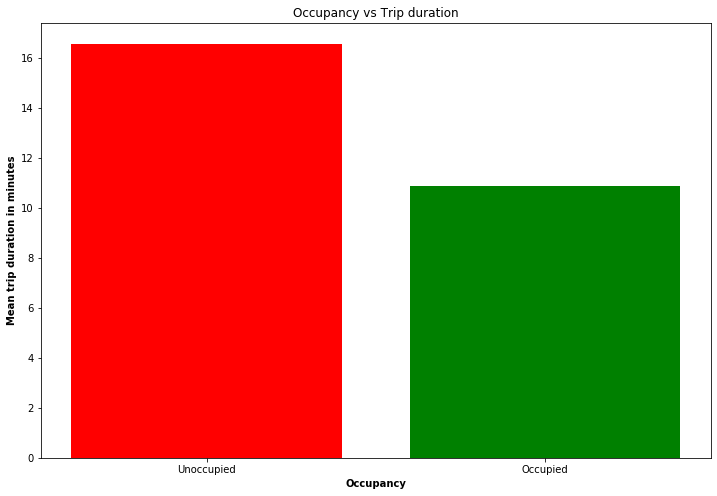

In [333]:
occupancy_duration = cab_data_rides_clean.groupby("occupancy").agg(
    {"trip_duration_minutes": "mean"}
)
occupancy_duration.reset_index(inplace=True)
occupancy_duration.rename(
    columns={"trip_duration_minutes": "mean_trip_duration_minutes"}, inplace=True
)
print(occupancy_duration.mean_trip_duration_minutes.values)

# Visualize through Bar plot
plt.figure(figsize=(12, 8))
plt.bar(
    ["Unoccupied", "Occupied"],
    occupancy_duration.mean_trip_duration_minutes.values,
    color=("red", "green"),
)
plt.xlabel("Occupancy", fontweight="bold")
plt.ylabel("Mean trip duration in minutes", fontweight="bold")
plt.title("Occupancy vs Trip duration")
plt.show()

Average trip duration of a taxi when occupied is around 11 minutes and when unoccupied is 16.5 minutes. This means that the taxis spend around 1.5 times the time they spend with passengers.

### 3.3.3 OCCUPANCY vs TRIP SPEED

Let's see the average speed per trip when the taxi is occupied and when it is unoccupied.

[ 7.28398711 12.59465033]


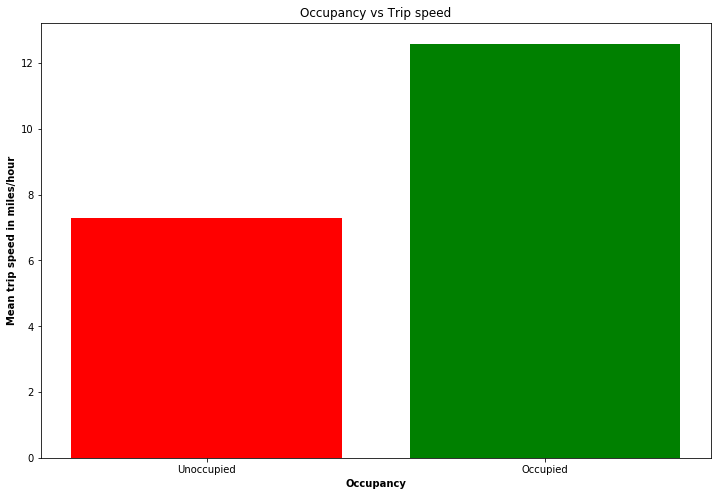

In [334]:
occupancy_speed = cab_data_rides_clean.groupby("occupancy").agg(
    {"speed_miles_per_hour": "mean"}
)
occupancy_speed.reset_index(inplace=True)
occupancy_speed.rename(
    columns={"speed_miles_per_hour": "mean_speed_miles_per_hour"}, inplace=True
)
print(occupancy_speed.mean_speed_miles_per_hour.values)

# Visualize through Bar plot
plt.figure(figsize=(12, 8))
plt.bar(
    ["Unoccupied", "Occupied"],
    occupancy_speed.mean_speed_miles_per_hour.values,
    color=("red", "green"),
)
plt.xlabel("Occupancy", fontweight="bold")
plt.ylabel("Mean trip speed in miles/hour", fontweight="bold")
plt.title("Occupancy vs Trip speed")
plt.show()

Average trip speed of a taxi when occupied is around 12.6 miles/hour and when unoccupied is 7.3 miles/hour. This means that the taxis are much slower when without passenger than with passengers.

### 3.3.4 DEMAND vs DAY OF THE WEEK

Let's see on which day of the week, the demand of taxis are more. Here we are only considering the trips when there are occupied by passengers.

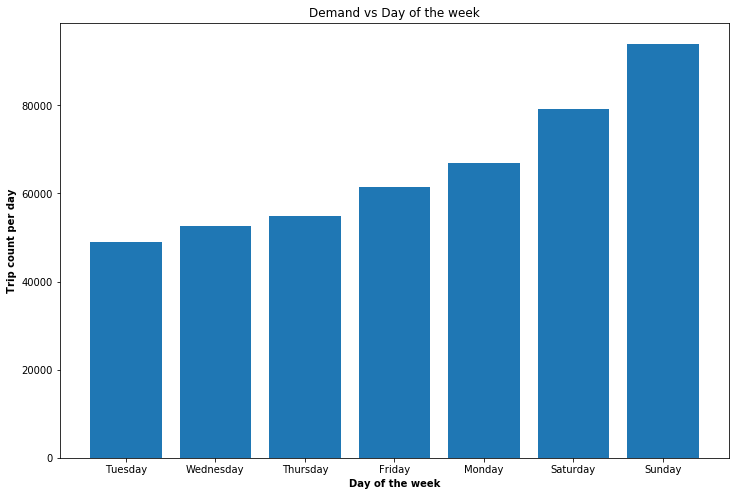

In [335]:
occupancy_dayOfTheWeek = (
    cab_data_rides_clean[cab_data_rides_clean.occupancy == 1]
    .groupby("day_of_week")
    .agg({"phase_of_day": "count"})
)
occupancy_dayOfTheWeek.reset_index(inplace=True)
occupancy_dayOfTheWeek.rename(columns={"phase_of_day": "trip_count"}, inplace=True)
occupancy_dayOfTheWeek.sort_values(by="trip_count", inplace=True)

# Visualize through Bar plot
plt.figure(figsize=(12, 8))
plt.bar(
    occupancy_dayOfTheWeek.day_of_week.values, occupancy_dayOfTheWeek.trip_count.values
)
plt.xlabel("Day of the week", fontweight="bold")
plt.ylabel("Trip count per day", fontweight="bold")
plt.title("Demand vs Day of the week")
plt.show()

It looks like that the weekend has more demand than other days of the week.

### 3.3.5 DEMAND vs WEEKDAY-WEEKEND

Let's see how the demand of taxis varies over weekdays and weekend. Here we are only considering the trips when there are occupied by passengers.

[86545 56980]


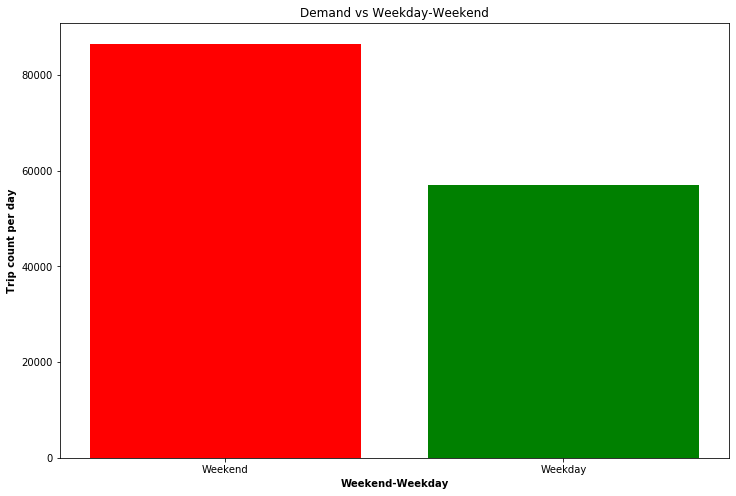

In [336]:
occupancy_isWeekend = (
    cab_data_rides_clean[cab_data_rides_clean.occupancy == 1]
    .groupby("isWeekend")
    .agg({"phase_of_day": "count"})
)
occupancy_isWeekend.reset_index(inplace=True)
occupancy_isWeekend.rename(columns={"phase_of_day": "trip_count"}, inplace=True)
occupancy_isWeekend.sort_values(by="trip_count", inplace=True)

occupancy_isWeekend.loc[occupancy_isWeekend.isWeekend == 1, "trip_count"] = math.floor(
    occupancy_isWeekend[occupancy_isWeekend.isWeekend == 1].trip_count / 2
)
occupancy_isWeekend.loc[occupancy_isWeekend.isWeekend == 0, "trip_count"] = math.floor(
    occupancy_isWeekend[occupancy_isWeekend.isWeekend == 0].trip_count / 5
)
print(occupancy_isWeekend.trip_count.values)

# Visualize through Bar plot
plt.figure(figsize=(12, 8))
plt.bar(
    ["Weekend", "Weekday"],
    occupancy_isWeekend.trip_count.values,
    color=("red", "green"),
)
plt.xlabel("Weekend-Weekday", fontweight="bold")
plt.ylabel("Trip count per day", fontweight="bold")
plt.title("Demand vs Weekday-Weekend")
plt.show()

It looks like that the demand from passengers are 1.5 times on weekends in comparison to weekdays.

### 3.3.6 DEMAND vs PHASE OF THE DAY

Let's see how the demand of taxis varies over different phases of the day. Here we are only considering the trips when there are occupied by passengers.

[ 65346  77366 125417 189866]


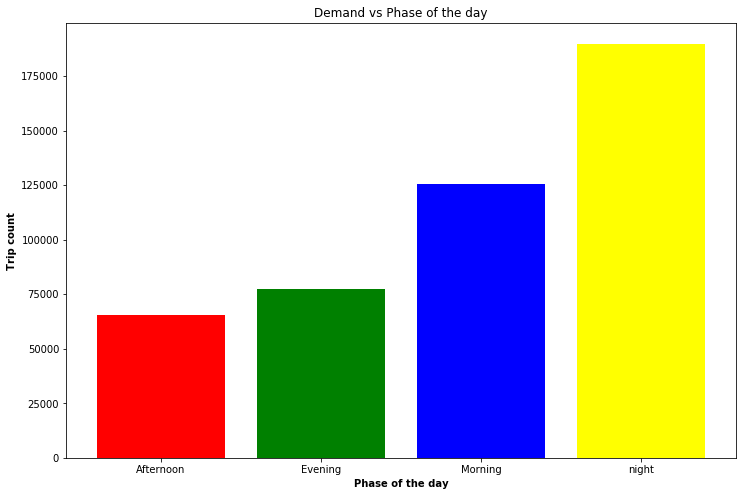

In [339]:
occupancy_phaseOfTheDay = (
    cab_data_rides_clean[cab_data_rides_clean.occupancy == 1]
    .groupby("phase_of_day")
    .agg({"day_of_week": "count"})
)
occupancy_phaseOfTheDay.reset_index(inplace=True)
occupancy_phaseOfTheDay.rename(columns={"day_of_week": "trip_count"}, inplace=True)
occupancy_phaseOfTheDay.sort_values(by="trip_count", inplace=True)
print(occupancy_phaseOfTheDay.trip_count.values)

# Visualize through Bar plot
plt.figure(figsize=(12, 8))
plt.bar(
    occupancy_phaseOfTheDay.phase_of_day.values,
    occupancy_phaseOfTheDay.trip_count.values,
    color=("red", "green", "blue", "yellow"),
)
plt.xlabel("Phase of the day", fontweight="bold")
plt.ylabel("Trip count", fontweight="bold")
plt.title("Demand vs Phase of the day")
plt.show()

It looks like that the demand from passengers are the higher during NIGHT (from 21:00 till 5:00) and MORNING (from 5:00 till 12:00). The demand is least during AFTERNOON (from 12:00 till 17:00) and EVENING (from 17:00 till 21:00)

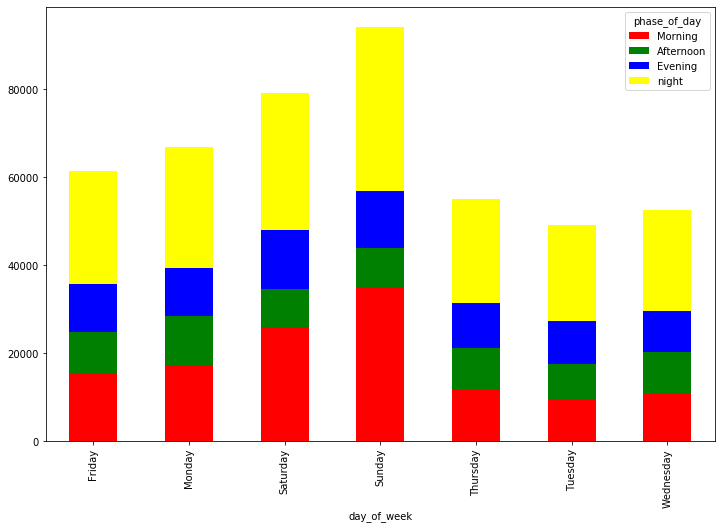

In [386]:
occupancy_dayOfWeek_phaseOfTheDay = (
    cab_data_rides_clean[cab_data_rides_clean.occupancy == 1]
    .groupby(["day_of_week", "phase_of_day"])
    .agg({"isWeekend": "count"})
)
occupancy_dayOfWeek_phaseOfTheDay.reset_index(inplace=True)
occupancy_dayOfWeek_phaseOfTheDay.rename(
    columns={"isWeekend": "trip_count"}, inplace=True
)

pivot_df = occupancy_dayOfWeek_phaseOfTheDay.pivot(
    index="day_of_week", columns="phase_of_day", values="trip_count"
)
pivot_df.loc[:, ["Morning", "Afternoon", "Evening", "night"]].plot.bar(
    stacked=True, color=("red", "green", "blue", "yellow"), figsize=(12, 8)
)

In [541]:
# Save file for backup
cab_data_rides_clean.to_csv("cab_data_rides_clean.csv", index=False)

In [ ]:
#cab_data_rides_clean = pd.read_csv("cab_data_rides_clean.csv", parse_dates=["startTime", "endTime"])

## 3.4 Data transformation

### 3.4.1 Calculate ride behaviour of taxis

In order to segment the taxi cab driver, we need to find properties/behaviour per taxi driver. The properties/behaviour can be further divided into two parts. One part being the behaviour of driver when with passengers and other being without passengers.

In [562]:
# Separation of passenger occupied rides and unoccupied rides
cab_data_rides_clean_occupied = cab_data_rides_clean[
    cab_data_rides_clean.occupancy == 1
]
cab_data_rides_clean_unoccupied = cab_data_rides_clean[
    cab_data_rides_clean.occupancy == 0
]

Here we calculate taxi cab's driving properties/behaviour when it is with passengers.

In [563]:
# Properties/behaviour of taxis during the rides when occupied by passengers
cab_occupied_general = cab_data_rides_clean_occupied.groupby("cab_no").agg(
    {
        "startLatitude": "count",
        "trip_distance_miles": "mean",
        "trip_duration_minutes": "mean",
        "speed_miles_per_hour": "mean",
    }
)
cab_occupied_general.reset_index(inplace=True)
cab_occupied_general.rename(
    columns={
        "startLatitude": "trip_count",
        "trip_distance_miles": "mean_trip_distance_occupied",
        "trip_duration_minutes": "mean_trip_duration_occupied",
        "speed_miles_per_hour": "mean_speed_occupied",
    },
    inplace=True,
)
cab_occupied_general.head(2)

,cab_no,trip_count,mean_trip_distance_occupied,mean_trip_duration_occupied,mean_speed_occupied
0,1,934,2.176210,9.982002,11.966103
1,2,24,1.774167,9.888333,10.549167


Here we calculate taxi cab's driving properties/behaviour when it is looking for passengers i.e. unoccupied.

In [564]:
# Properties/behaviour of taxis during the rides when not occupied by passengers
cab_unoccupied_general = cab_data_rides_clean_unoccupied.groupby("cab_no").agg(
    {
        "trip_distance_miles": "sum",
        "trip_duration_minutes": "sum",
        "speed_miles_per_hour": "sum",
    }
)
cab_unoccupied_general.reset_index(inplace=True)
cab_unoccupied_general.rename(
    columns={
        "trip_distance_miles": "sum_trip_distance_unoccupied",
        "trip_duration_minutes": "sum_trip_duration_unoccupied",
        "speed_miles_per_hour": "sum_speed_unoccupied",
    },
    inplace=True,
)
cab_unoccupied_general.head(2)

,cab_no,sum_trip_distance_unoccupied,sum_trip_duration_unoccupied,sum_speed_unoccupied
0,1,1085.69,12288.45,6096.36
1,2,25.52,621.23,248.30


Here we join taxi cab's driving properties/behaviour when it is with passengers and without passengers.

In [565]:
# Join these two separate properies of taxis in one dataframe
cab_all_properties = cab_occupied_general.merge(
    cab_unoccupied_general, how="inner", left_on="cab_no", right_on="cab_no"
)

cab_all_properties["mean_trip_distance_unoccupied"] = (
    cab_all_properties["sum_trip_distance_unoccupied"]
    / cab_all_properties["trip_count"]
)
cab_all_properties["mean_trip_duration_unoccupied"] = (
    cab_all_properties["sum_trip_duration_unoccupied"]
    / cab_all_properties["trip_count"]
)
cab_all_properties["mean_speed_unoccupied"] = (
    cab_all_properties["sum_speed_unoccupied"] / cab_all_properties["trip_count"]
)
cab_all_properties.drop(
    [
        "sum_trip_distance_unoccupied",
        "sum_trip_duration_unoccupied",
        "sum_speed_unoccupied",
    ],
    axis=1,
    inplace=True,
)

cab_all_properties.head(2)

,cab_no,trip_count,mean_trip_distance_occupied,mean_trip_duration_occupied,mean_speed_occupied,mean_trip_distance_unoccupied,mean_trip_duration_unoccupied,mean_speed_unoccupied
0,1,934,2.176210,9.982002,11.966103,1.162409,13.156799,6.527152
1,2,24,1.774167,9.888333,10.549167,1.063333,25.884583,10.345833


Here we calculate taxi cabs are fulfilling the customer demands during the peak times (weekend and morning/night phases of the day).

In [566]:
# Properties/behaviour of taxis during the rides during the weekend (high demand)
cab_demand_fulfilment = (
    cab_data_rides_clean_occupied[
        (cab_data_rides_clean_occupied.isWeekend == 1)
        | (
            (cab_data_rides_clean_occupied.phase_of_day == "night")
            | (cab_data_rides_clean_occupied.phase_of_day == "Morning")
        )
    ]
    .groupby(["cab_no"])
    .agg({"startLatitude": "count"})
)
cab_demand_fulfilment.reset_index(inplace=True)
cab_demand_fulfilment.rename(
    columns={"startLatitude": "trip_count_high_demand"}, inplace=True
)
cab_demand_fulfilment.head(2)

,cab_no,trip_count_high_demand
0,1,724
1,2,17


Here we join the weekend demand fulfilment properties of the cab to previous properties gathered.

In [567]:
# Join these weekend demand property to the mail properties dataframe
cab_all_properties = cab_all_properties.merge(
    cab_demand_fulfilment, how="inner", left_on="cab_no", right_on="cab_no"
)
cab_all_properties["demand_fulfilment_index"] = (
    cab_all_properties["trip_count_high_demand"] / cab_all_properties["trip_count"]
)
cab_all_properties.drop(["trip_count_high_demand"], axis=1, inplace=True)
cab_all_properties.head()

,cab_no,trip_count,mean_trip_distance_occupied,mean_trip_duration_occupied,mean_speed_occupied,mean_trip_distance_unoccupied,mean_trip_duration_unoccupied,mean_speed_unoccupied,demand_fulfilment_index
0,1,934,2.176210,9.982002,11.966103,1.162409,13.156799,6.527152,0.775161
1,2,24,1.774167,9.888333,10.549167,1.063333,25.884583,10.345833,0.708333
2,3,874,4.086247,12.374359,17.084211,3.052757,22.120229,8.956659,0.736842
3,4,1019,2.660039,11.284544,12.788587,1.431923,18.753288,6.595790,0.814524
4,5,391,2.465780,11.043939,12.399744,1.348798,14.042967,7.115294,0.787724


In [548]:
# Save file for backup
cab_all_properties.to_csv("cab_all_properties.csv", index=False)

In [982]:
cab_all_properties.columns

Index(['cab_no', 'trip_count', 'mean_trip_distance_occupied',
       'mean_trip_duration_occupied', 'mean_speed_occupied',
       'mean_trip_distance_unoccupied', 'mean_trip_duration_unoccupied',
       'mean_speed_unoccupied', 'demand_fulfilment_index', 'cluster_label'],
      dtype='object')

### 3.4.2 Handling the skewness of the data

In [572]:
cab_all_properties.skew()

cab_no                          -0.003277
trip_count                      -0.589665
mean_trip_distance_occupied      1.888654
mean_trip_duration_occupied      1.810136
mean_speed_occupied              1.687257
mean_trip_distance_unoccupied    2.392466
mean_trip_duration_unoccupied    1.671041
mean_speed_unoccupied            1.520182
demand_fulfilment_index         -0.188288
dtype: float64

Skewness = 0 --> symmetrical distribution 

Skewness < 0 --> Negative skewed or left skewed or tail towards left (log/Square/cube transformation)

Skewness > 0 --> Positive skewed or Right skewed or tail towards Right (log/SquareRoot/CubeRoot transformation)

Good skewness score is between -0.5 to 0.5

So, we can leave trip_count and demand_fulfilment_index as their skewness is not so bad.

Other columns have positive skewness (right skewed i.e. tail to the right) 

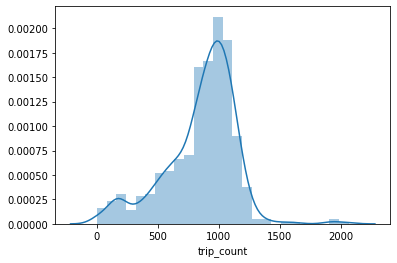

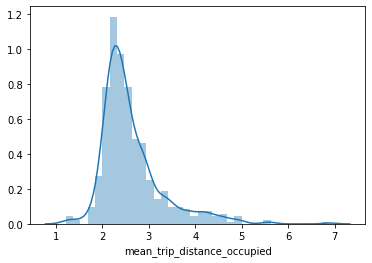

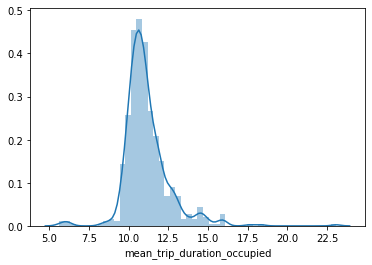

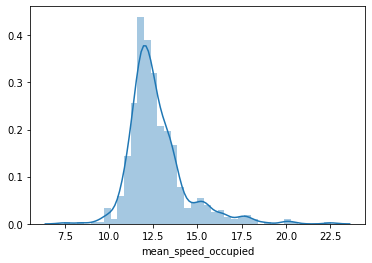

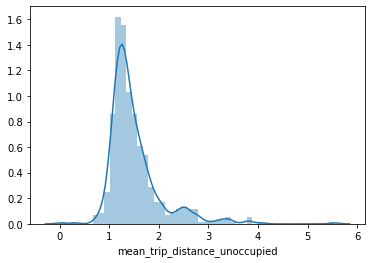

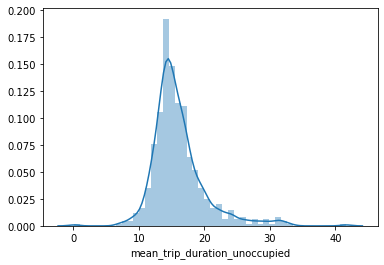

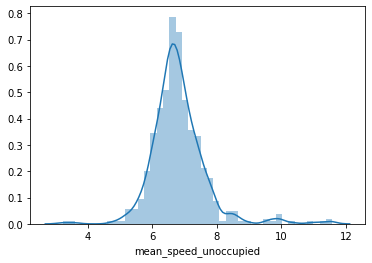

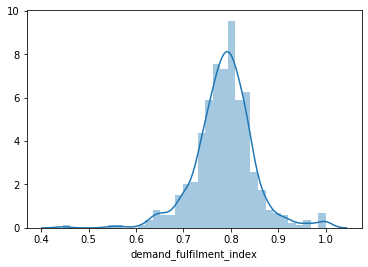

In [569]:
for column in cab_all_properties:
    if column != "cab_no":
        sns.distplot(cab_all_properties[column])
        plt.show()

Here we see that most of the features are highly skewed because of presence of outliers. We can apply log or sqrt or cube root transformation to handle the skewness of the positive skewed features.

trip_count, demand_fulfilment_index (no action)

mean_trip_distance_occupied, mean_trip_duration_occupied, mean_speed_occupied, mean_speed_unoccupied (log)

mean_trip_distance_unoccupied (cuberoot)

mean_trip_duration_unoccupied (sqrt)

In [570]:
cab_all_properties_transformed = cab_all_properties.copy()

cab_all_properties_transformed[
    [
        "mean_trip_distance_occupied",
        "mean_trip_duration_occupied",
        "mean_speed_occupied",
        "mean_speed_unoccupied",
    ]
] = np.log(
    cab_all_properties_transformed[
        [
            "mean_trip_distance_occupied",
            "mean_trip_duration_occupied",
            "mean_speed_occupied",
            "mean_speed_unoccupied",
        ]
    ]
)
cab_all_properties_transformed[["mean_trip_distance_unoccupied"]] = (
    cab_all_properties_transformed[["mean_trip_distance_unoccupied"]]
) ** (1 / 3)
cab_all_properties_transformed[["mean_trip_duration_unoccupied"]] = np.sqrt(
    cab_all_properties_transformed[["mean_trip_duration_unoccupied"]]
)

In [571]:
cab_all_properties_transformed.skew()

cab_no                          -0.003277
trip_count                      -0.589665
mean_trip_distance_occupied      0.844878
mean_trip_duration_occupied      0.102163
mean_speed_occupied              0.938271
mean_trip_distance_unoccupied    0.528113
mean_trip_duration_unoccupied    0.373552
mean_speed_unoccupied            0.192533
demand_fulfilment_index         -0.188288
dtype: float64

In [573]:
cab_all_properties_transformed.head(2)

,cab_no,trip_count,mean_trip_distance_occupied,mean_trip_duration_occupied,mean_speed_occupied,mean_trip_distance_unoccupied,mean_trip_duration_unoccupied,mean_speed_unoccupied,demand_fulfilment_index
0,1,934,0.777585,2.300784,2.482078,1.051444,3.627230,1.875971,0.775161
1,2,24,0.573331,2.291356,2.356047,1.020680,5.087689,2.336584,0.708333


### 3.4.3 Standardization (scaling) the data

This is done to bring all the features to same scale. Mean = 0 and SD = 1.

In [574]:
# Define the scaler
scaler = StandardScaler()

# Standardize the data
cab_all_properties_transformed.loc[
    :, cab_all_properties_transformed.columns != "cab_no"
] = scaler.fit_transform(
    cab_all_properties_transformed.loc[
        :, cab_all_properties_transformed.columns != "cab_no"
    ]
)

cab_all_properties_transformed.head(2)

,cab_no,trip_count,mean_trip_distance_occupied,mean_trip_duration_occupied,mean_speed_occupied,mean_trip_distance_unoccupied,mean_trip_duration_unoccupied,mean_speed_unoccupied,demand_fulfilment_index
0,1,0.274259,-0.704456,-0.794121,-0.425440,-0.658571,-0.693893,-0.290663,-0.191833
1,2,-2.863736,-1.609992,-0.868989,-1.460991,-0.907974,2.222768,3.510790,-1.268958


## 3.5 Machine learning modeling

### 3.5.1 K-Means

For K-Means algorithm, we need to provide the number of cluster beforehand. As we have no idea of effective numbers of clusters, we can decide that based on 'Elbow criterion'.

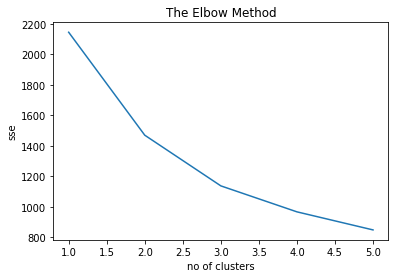

In [593]:
# Sort the data based on cab no
cab_all_properties_transformed.sort_values(by=["cab_no"], inplace=True)

# Input data considered for clustering
cluser_input = cab_all_properties_transformed[
    [
        "trip_count",
        "mean_speed_occupied",
        "mean_trip_distance_unoccupied",
        "demand_fulfilment_index",
    ]
]

# Create a list to capture the 'within-cluster sum-of-square-errors (SSE)' i.e. sum of squared distances from every data point to their cluster centre.
sse = []

# Try KMeans clustering with different number of clusters
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(cluser_input)
    sse.append(kmeans.inertia_)  # sum of squared distances to closest cluster center

# Elbow curve to find suitable number of clusters
plt.plot(range(1, 6), sse)
plt.title("The Elbow Method")
plt.xlabel("no of clusters")
plt.ylabel("sse")
plt.show()

It seems that the ideal number of clusters is 3, as we don't see lot of improvement in sse with cluster number 4 and 5.

In [602]:
# Build final model
final_kmeans = KMeans(n_clusters=3, random_state=1)

# Cluster labels for each taxi
cluser_labels = final_kmeans.fit_predict(cluser_input)

# Cluster centres
cluser_centroids = final_kmeans.cluster_centers_

Let's add the cluster labels to the taxi data (non transformed data).

In [607]:
# First sort the data as per taxi number
cab_all_properties.sort_values(by=["cab_no"], inplace=True)

# Assign the cluster label
cab_all_properties["cluster_label"] = cluser_labels

In [609]:
cab_all_properties.head(2)

,cab_no,trip_count,mean_trip_distance_occupied,mean_trip_duration_occupied,mean_speed_occupied,mean_trip_distance_unoccupied,mean_trip_duration_unoccupied,mean_speed_unoccupied,demand_fulfilment_index,cluster_label
0,1,934,2.176210,9.982002,11.966103,1.162409,13.156799,6.527152,0.775161,1
1,2,24,1.774167,9.888333,10.549167,1.063333,25.884583,10.345833,0.708333,0


### 3.5.2 Cluster profile

After we cluster we have to term each cluster based on its characteristics.

In [612]:
cluster_profile_data = cab_all_properties.groupby("cluster_label").agg(
    {
        "cab_no": "count",
        "trip_count": "mean",
        "mean_trip_distance_occupied": "mean",
        "mean_trip_duration_occupied": "mean",
        "mean_speed_occupied": "mean",
        "mean_trip_distance_unoccupied": "mean",
        "mean_trip_duration_unoccupied": "mean",
        "mean_speed_unoccupied": "mean",
        "demand_fulfilment_index": "mean",
    }
)
cluster_profile_data.reset_index(inplace=True)
cluster_profile_data.rename(columns={"cab_no": "cab_count"}, inplace=True)
cluster_profile_data.head()

,cluster_label,cab_count,trip_count,mean_trip_distance_occupied,mean_trip_duration_occupied,mean_speed_occupied,mean_trip_distance_unoccupied,mean_trip_duration_unoccupied,mean_speed_unoccupied,demand_fulfilment_index
0,0,54,299.018519,2.314802,11.253137,11.669555,1.224648,14.884290,6.630751,0.861023
1,1,395,982.017722,2.407011,10.702624,12.234896,1.341269,14.922200,6.735543,0.785569
2,2,87,620.114943,3.785242,12.938013,15.448821,2.427783,21.886852,7.269769,0.747934


**Based on the above data, we can conclude below characteristics about the clusters**

**1st cluster**
    1. Less number of cabs in this group
    2. Make less number of trips
    3. Make small distance trips
    4. Ride with less speed
    5. Spend less distance and time looking for passengers
    6. High demand fulfilment score
    
**2nd cluster**
    1. Most number of cabs in this group
    2. Make high number of trips
    3. Normal coverage range and normal ride speed
    4. Spend not too less, not too much distance and time looking for passengers
    5. Average demand fulfilment score.    
    
**3rd cluster**
    1. Less number of cabs in this group
    2. Make not too number of trips
    3. High coverage range and high ride speed. 
    4. Spend maximum distance and time looking for passengers
    5. Low demand fulfilment score.       
    
    
Based on these characteristics, we can name the clusters.

**1st cluster** : Luxurious, safer and customer friendly cabs

**2nd cluster** : Normal cabs with nothing extraordinary

**3rd cluster** : Rash, inefficient and not customer friendly cabs

# 4. Predictor for cab drivers, predicting the next place of a passenger

**Business/Real World Problem**<br><br>
For a given location in SF, our goal is to predict the number of pickups in that given location. Some location require more taxis at a particular time than other locations owing to the presence schools, hospitals, offices etc. The prediction result can be transferred to the taxi drivers via Smartphone app, and they can subsequently move to the locations where predicted pickups are high.

<b>Objectives:</b> 
Our objective is to predict the number of pickups as accurately as possible for each region in a 10 min interval. We will break up the whole SF city into regions. Now, the 10 min interval is chosen because in SF, one can commute around 2 miles in approximately 10 minutes given the traffic is normal at that particular time.

<b>Constraints:</b>
* <b>Latency:</b> Given a location and current time of a taxi driver, as a taxi driver, he/she excepts to get the predicted pickups in his/her region and the adjoining regions in few seconds. Hence, there is a medium latency requirement.<br><br>

* <b>Interpretability:</b> As long as taxi driver gets good prediction result, he/she is not be much interested in the interpretability of the result. He/she is not much interested in why he/she is getting this result. Hence, there is a no interpretability required.<br><br>

* <b>Relative Errors:</b> Mean Absolute Percentage Error will be the relative error we will consider. Let say the predicted pickups for a particular location are 100, but actual pickups are 102, the percentage error will be 2% and Absolute error is 2. The taxi driver will be more interested in the percentage error than the absolute error. Let say in some region the predicted pickups are 250, and if taxi driver knows that the relative error is 10% then he/she will consider the predicted result to be in the range of 225 to 275, which is considerable.

<b>Our goal is to reduce the percentage error is low as possible.</b> 

## 4.1 Feature engineering

Here we will ceate new features from extisting features.

### 4.1.1 Create regions (using clustering technique) from pickup longitude and latitude

Here we divide SF city into different areas where taxis can operate. We will find these areas by clustering nearest pickup locations of taxis.

For this use case, we will use the 'cab_data_rides_clean' that we prepared in the previous stages. From this dataset, we only need the rides where the taxis were occupied by passengers.

In [743]:
cab_data_rides_clean_occupied = cab_data_rides_clean[
    cab_data_rides_clean.occupancy == 1
]
cab_data_rides_clean_occupied.head(2)

,cab_no,startLatitude,endLatitude,startLongitude,endLongitude,startTime,endTime,occupancy,trip_distance_miles,trip_duration_minutes,speed_miles_per_hour,day_of_week,isWeekend,phase_of_day
1,1,37.74977,37.75580,-122.39724,-122.41441,2008-05-17 14:51:10,2008-05-17 14:56:00,1,1.03,4.83,12.80,Saturday,1,Afternoon
3,1,37.75053,37.75177,-122.42086,-122.43095,2008-05-17 15:18:06,2008-05-17 15:21:50,1,0.56,3.73,9.01,Saturday,1,Afternoon


In [744]:
coord = cab_data_rides_clean_occupied[["startLatitude", "startLongitude"]].values
neighbors = []


def min_distance(regionCenters, totalClusters):
    good_points = 0
    bad_points = 0
    less_dist = []
    more_dist = []
    min_distance = 100000  # any big number can be given here
    for i in range(totalClusters):
        good_points = 0
        bad_points = 0
        for j in range(totalClusters):
            if j != i:
                distance = round(
                    haversine(
                        (regionCenters[i][0], regionCenters[i][1]),
                        (regionCenters[j][0], regionCenters[j][1]),
                        unit=Unit.MILES,
                    ),
                    2,
                )
                min_distance = min(
                    min_distance, distance
                )  # it will return minimum of "min_distance, distance".
                if distance < 2:
                    good_points += 1
                else:
                    bad_points += 1
        less_dist.append(good_points)
        more_dist.append(bad_points)
    print("On choosing a cluster size of {}".format(totalClusters))
    print(
        "Avg. Number clusters within vicinity where inter cluster distance < 2 miles is {}".format(
            np.ceil(sum(less_dist) / len(less_dist))
        )
    )
    print(
        "Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is {}".format(
            np.ceil(sum(more_dist) / len(more_dist))
        )
    )
    print("Minimum distance between any two clusters = {}".format(min_distance))
    print("-" * 10)


def makingRegions(noOfRegions):
    regions = MiniBatchKMeans(n_clusters=noOfRegions, batch_size=10000).fit(coord)
    regionCenters = regions.cluster_centers_
    totalClusters = len(regionCenters)
    return regionCenters, totalClusters

In [745]:
startTime = datetime.now()
for i in range(10, 100, 10):
    regionCenters, totalClusters = makingRegions(i)
    min_distance(regionCenters, totalClusters)
print("Time taken = " + str(datetime.now() - startTime))

On choosing a cluster size of 10
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 2.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 7.0
Minimum distance between any two clusters = 0.87
----------
On choosing a cluster size of 20
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 4.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 16.0
Minimum distance between any two clusters = 0.68
----------
On choosing a cluster size of 30
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 9.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 21.0
Minimum distance between any two clusters = 0.22
----------
On choosing a cluster size of 40
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 10.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 30.0
Mini

**Assumption:** We want the minimum distance between any two clusters to be less than 0.5miles and when number of clusters are 30 then this condition is almost meeting. Therefore, we are considering number of clusters to be 30.

In [825]:
cab_data_rides_clean_occupied_pred = cab_data_rides_clean_occupied.copy()
no_of_clusters = 30

coord = cab_data_rides_clean_occupied_pred[["startLatitude", "startLongitude"]].values
regions = MiniBatchKMeans(n_clusters=no_of_clusters, batch_size=10000).fit(coord)
cab_data_rides_clean_occupied_pred["pickup_cluster"] = regions.predict(
    cab_data_rides_clean_occupied_pred[["startLatitude", "startLongitude"]]
)

In [826]:
cab_data_rides_clean_occupied_pred.head(2)

,cab_no,startLatitude,endLatitude,startLongitude,endLongitude,startTime,endTime,occupancy,trip_distance_miles,trip_duration_minutes,speed_miles_per_hour,day_of_week,isWeekend,phase_of_day,pickup_cluster
1,1,37.74977,37.75580,-122.39724,-122.41441,2008-05-17 14:51:10,2008-05-17 14:56:00,1,1.03,4.83,12.80,Saturday,1,Afternoon,14
3,1,37.75053,37.75177,-122.42086,-122.43095,2008-05-17 15:18:06,2008-05-17 15:21:50,1,0.56,3.73,9.01,Saturday,1,Afternoon,19


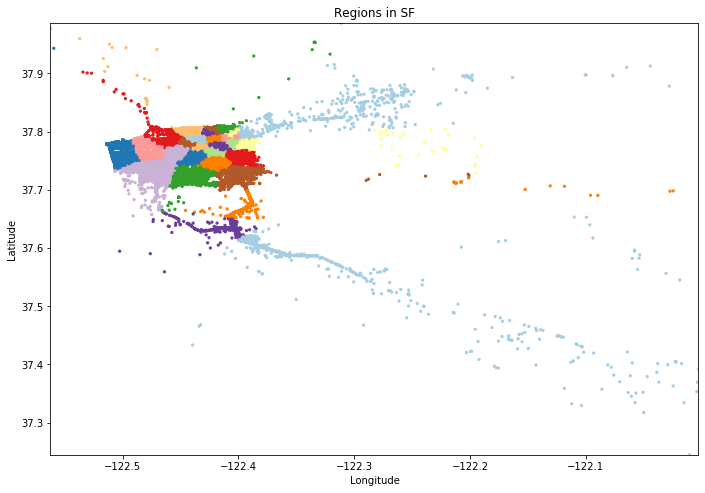

In [827]:
latitude_range = (
    cab_data_rides_clean_occupied_pred.startLatitude.min(),
    cab_data_rides_clean_occupied_pred.startLatitude.max(),
)
Longitude_range = (
    cab_data_rides_clean_occupied_pred.startLongitude.min(),
    cab_data_rides_clean_occupied_pred.startLongitude.max(),
)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1.5, 1.5])
ax.scatter(
    x=cab_data_rides_clean_occupied_pred.startLongitude.values,
    y=cab_data_rides_clean_occupied_pred.startLatitude.values,
    c=cab_data_rides_clean_occupied_pred.pickup_cluster.values,
    cmap="Paired",
    s=5,
)
ax.set_xlim(
    cab_data_rides_clean_occupied_pred.startLongitude.min(),
    cab_data_rides_clean_occupied_pred.startLongitude.max(),
)
ax.set_ylim(
    cab_data_rides_clean_occupied_pred.startLatitude.min(),
    cab_data_rides_clean_occupied_pred.startLatitude.max(),
)
ax.set_title("Regions in SF")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

### 4.1.2 Time binning

Here we divide all taxi rides in different time bins of 10 mins.

Let's first create a new feature (pickup time in unix format) from the pick up time that is in datetime format.

In [828]:
all_data = cab_data_rides_clean_occupied_pred.copy()

In [829]:
def get_unixtime(data):
    return (data.astype(np.int64) / 1e9).astype(np.int64)


all_data["pickup_time_unix"] = all_data[["startTime"]].apply(get_unixtime)

all_data.head(2)

,cab_no,startLatitude,endLatitude,startLongitude,endLongitude,startTime,endTime,occupancy,trip_distance_miles,trip_duration_minutes,speed_miles_per_hour,day_of_week,isWeekend,phase_of_day,pickup_cluster,pickup_time_unix
1,1,37.74977,37.75580,-122.39724,-122.41441,2008-05-17 14:51:10,2008-05-17 14:56:00,1,1.03,4.83,12.80,Saturday,1,Afternoon,14,1211035870
3,1,37.75053,37.75177,-122.42086,-122.43095,2008-05-17 15:18:06,2008-05-17 15:21:50,1,0.56,3.73,9.01,Saturday,1,Afternoon,19,1211037486


In [830]:
def pickup_10min_bins(dataframe):
    pickupTime = dataframe["pickup_time_unix"].values
    unix_year = all_data.pickup_time_unix.min() - 1
    time_10min_bin = [int((i - unix_year) / 600) for i in pickupTime]
    dataframe["time_bin"] = np.array(time_10min_bin)
    return dataframe

In [831]:
all_data = pickup_10min_bins(all_data)
all_data.head(2)

,cab_no,startLatitude,endLatitude,startLongitude,endLongitude,startTime,endTime,occupancy,trip_distance_miles,trip_duration_minutes,speed_miles_per_hour,day_of_week,isWeekend,phase_of_day,pickup_cluster,pickup_time_unix,time_bin
1,1,37.74977,37.75580,-122.39724,-122.41441,2008-05-17 14:51:10,2008-05-17 14:56:00,1,1.03,4.83,12.80,Saturday,1,Afternoon,14,1211035870,29
3,1,37.75053,37.75177,-122.42086,-122.43095,2008-05-17 15:18:06,2008-05-17 15:21:50,1,0.56,3.73,9.01,Saturday,1,Afternoon,19,1211037486,31


In [832]:
all_data_timeBin_groupBy = (
    all_data[["pickup_cluster", "time_bin", "trip_distance_miles"]]
    .groupby(by=["pickup_cluster", "time_bin"])
    .count()
)
all_data_timeBin_groupBy.head()

trip_distance_miles
pickup_cluster time_bin                     
0              0                           6
               1                           1
               3                           1
               4                           1
               5                           3

In [833]:
time_bin_count = len(np.unique(all_data["time_bin"]))
print("Number of unique 10 minute time bins in the data: ", time_bin_count)

Number of unique 10 minute time bins in the data:  3439


### 4.1.3 Fill missing values for empty time bins

There can be several time bins, where there was no taxi rides. Here, we will assign zero values for such time bins.

In [834]:
# this function returns the indices of all the unique time_bins where there is a pickup for all the clusters.
def getUniqueBinsWithPickups(dataframe):
    values = []
    for i in range(no_of_clusters):
        cluster_id = dataframe[dataframe["pickup_cluster"] == i]
        unique_clus_id = list(set(cluster_id["time_bin"]))
        unique_clus_id.sort()  # inplace sorting
        values.append(unique_clus_id)
    return values

In [835]:
# we have to find out, how many time_bins are there where there is no pickup in any of the cluster region
unique_binswithPickup_all_data = getUniqueBinsWithPickups(all_data)

for i in range(no_of_clusters):
    print(
        "For cluster ID {}, total number of time bins with no pickup in this clutser region is {}".format(
            i, (time_bin_count - len(unique_binswithPickup_all_data[i]))
        )
    )
    print("-" * 90)

For cluster ID 0, total number of time bins with no pickup in this clutser region is 257
------------------------------------------------------------------------------------------
For cluster ID 1, total number of time bins with no pickup in this clutser region is 775
------------------------------------------------------------------------------------------
For cluster ID 2, total number of time bins with no pickup in this clutser region is 236
------------------------------------------------------------------------------------------
For cluster ID 3, total number of time bins with no pickup in this clutser region is 248
------------------------------------------------------------------------------------------
For cluster ID 4, total number of time bins with no pickup in this clutser region is 1752
------------------------------------------------------------------------------------------
For cluster ID 5, total number of time bins with no pickup in this clutser region is 218
----------

There are two ways to fill up these values:

* Fill the missing value with 0's.

In [836]:
# Fill the missing value with 0's.
# above function performs the operation in this way: if in any cluster if there is no pickup in any of the time bins, then
# it simply appends 0 in that missing time_bin else it adds the original number of pickups in that time_bins.


def fillMissingWithZero(numberOfPickups, correspondingTimeBin):
    ind = 0
    smoothed_regions = []
    for c in range(0, no_of_clusters):
        smoothed_bins = []
        for t in range(time_bin_count):
            if t in correspondingTimeBin[c]:
                smoothed_bins.append(numberOfPickups[ind])
                ind += 1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [837]:
all_data_fillZero = fillMissingWithZero(
    all_data_timeBin_groupBy["trip_distance_miles"].values,
    unique_binswithPickup_all_data,
)

In [838]:
def countZeros(num):
    count = 0
    for i in num:
        if i == 0:
            count += 1
    return count


print(
    "Number of values filled with zero in zero fill train data= "
    + str(countZeros(all_data_fillZero))
)

Number of values filled with zero in zero fill train data= 18550


There are total 30 clusters. Each cluster has 3439 time bins. After smoothing or fillWithZero, each of 3439 time bin has a pickup. So, there should be a total of <b>3439*30 = 103170</b> pickup values present. Let's Check, is it correct?

In [839]:
print("Total number of pickup values = ", len(all_data_fillZero))

Total number of pickup values =  103170


In [840]:
regionWisePickup_all_data = []

for i in range(no_of_clusters):
    regionWisePickup_all_data.append(
        all_data_fillZero[time_bin_count * i : ((time_bin_count * i) + time_bin_count)]
    )

# "regionWisePickup_all_data" is a list of lists which contains 30 sub lists, where the index of each sub-list is the
# corresponding cluster number and the element of each sub-list is the pickup value. So, we know that there are
# 3439 time bins, hence each sub-list is of size 3439.

In [841]:
print(len(regionWisePickup_all_data), len(regionWisePickup_all_data[0]))

30 3439


## 4.2 Data transformation for modeling

Before we move to modeling, we have to transform the available data in such a way that it fits the need of the ML models.
It prepares data in cumulative form (time bin) which will be later split into test and train.

There are total 30 clusters and each cluster has total 3439 time bins. So for 30 clusters there will be 3439*30 = 103170 pickup values.

In [889]:
# "regionWisePickup_all_data" is a list of lists which contains 30 sub lists, where the index of each sub-list is the
# corresponding cluster number and the element of each sub-list is the pickup value. So, we know that there are 3439
# time bins, hence, each sub-list is of size 3439.

# "regionWisePickup_all_data" is a list of lists [[x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], .. 30 lists]
# Here, x1,x2,x3... are pickup values at time stamp 1,2,3... respectively

# we take number of pickups that are happened in last 5 10min intervals
number_of_time_stamps = 5

# It will be used as true labels. Since we are taking previous 5 pickups as a training data (inut) for predicting
# next pickup, here next pickup will be a true/ground truth pickup i.e. "TruePickups"
TruePickups = []


# latitude of cluster center for every cluster
lat = []


# longitude of cluster center for every cluster
lon = []

# sunday = 0, monday = 1, tue = 2, wed = 3, thur = 4, fri = 5, sat = 6
day_of_week = []

# feat is a numbpy array, of shape (103170, 5) --> (3439*30, 4)
# each row corresponds to an entry in our data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1st 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
feat = []

centerOfRegions = regions.cluster_centers_
feat = [0] * number_of_time_stamps
for i in range(no_of_clusters):
    lat.append([centerOfRegions[i][0]] * (time_bin_count - number_of_time_stamps))
    lon.append([centerOfRegions[i][1]] * (time_bin_count - number_of_time_stamps))

    minUnixTime = all_data.pickup_time_unix.min()
    day_of_week.append(
        [
            pd.to_datetime((minUnixTime + 600 * j), unit="s").dayofweek
            for j in range(0, (time_bin_count - number_of_time_stamps))
        ]
    )

    feat = np.vstack(
        (
            feat,
            [
                regionWisePickup_all_data[i][k : k + number_of_time_stamps]
                for k in range(0, (time_bin_count - number_of_time_stamps))
            ],
        )
    )

    # output contains pickup values of all the regions and of each time stamp, except first 5 time stamp pickups of each region.
    TruePickups.append(regionWisePickup_all_data[i][number_of_time_stamps:])

feat = feat[1:]

In [890]:
len(lat[0]) * len(lat) == len(lon[0]) * len(lon) == len(day_of_week[0]) * len(
    day_of_week
) == (time_bin_count - number_of_time_stamps) * no_of_clusters == len(feat) == len(
    TruePickups[0]
) * len(
    TruePickups
)

True

In [891]:
feat

array([[6, 1, 0, 1, 1],
       [1, 0, 1, 1, 3],
       [0, 1, 1, 3, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=int64)

### 4.2.1 Adding Predictions of Weighted Moving Average Predictions as a feature in our data

Here we will try to get the predictions using weighted Auto regressors (previous observatios) to be used as features in cumulative form.

Upto now we computed 8 features for every data point that starts from 50th min of the day.
    1. cluster center latitude
    2. cluster center longitude
    3. day of the week 
    4. f_t_1: number of pickups that are happened previous t-1st 10min interval
    5. f_t_2: number of pickups that are happened previous t-2nd 10min interval
    6. f_t_3: number of pickups that are happened previous t-3rd 10min interval
    7. f_t_4: number of pickups that are happened previous t-4th 10min interval
    8. f_t_5: number of pickups that are happened previous t-5th 10min interval

The simple AR Model gives equal importance to all the values in the previous timebin data. However we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted importance converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones<br>

Weighted AR using weighted Values: $Y_t = [N * Y_{t-1} + (N-1) * Y_{t-2} + (N-2) * Y_{T-3} + ...) / N * (N+1)/2$

In [892]:
# "predicted_pickup_values": it is a temporary array that store weighted AR prediction values for each 10min intervl,
# For each cluster it will get reset. For every cluster it contains 3439 values
predicted_pickup_values = []

# "predicted_pickup_values_list" is a list of lists [[x5,x6,x7..x4463], [x5,x6,x7..x4463], [x5,x6,x7..x4463], ... 40 lists]
predicted_pickup_values_list = []

# it will contain cuurent predicted_value. Default is given -1 which will be replaced later
predicted_value = -1

window_size = 2
for i in range(no_of_clusters):
    for j in range(time_bin_count):
        if j == 0:
            predicted_value = regionWisePickup_all_data[i][j]
            predicted_pickup_values.append(0)
        else:
            if j >= window_size:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(window_size, 0, -1):
                    sumPickups += k * (
                        regionWisePickup_all_data[i][j - window_size + (k - 1)]
                    )
                    sumOfWeights += k
                predicted_value = int(sumPickups / sumOfWeights)
                predicted_pickup_values.append(predicted_value)
            else:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(j, 0, -1):
                    sumPickups += k * regionWisePickup_all_data[i][k - 1]
                    sumOfWeights += k
                predicted_value = int(sumPickups / sumOfWeights)
                predicted_pickup_values.append(predicted_value)

    predicted_pickup_values_list.append(predicted_pickup_values[5:])
    predicted_pickup_values = []

In [893]:
len(predicted_pickup_values_list[0]) * len(predicted_pickup_values_list) == (
    time_bin_count - number_of_time_stamps
) * 30

True

### 4.2.2 Train Test split

Before we start predictions using ML models, we need to split our data such that in every region we have 80% data in train and 20% in test, ordered date-wise for every region.

In [900]:
train_size_each_cluster = int((time_bin_count - number_of_time_stamps) * 0.8)
test_size_each_cluster = int((time_bin_count - number_of_time_stamps) * 0.2)

print("size of train data for one cluster:", train_size_each_cluster)
print("size of total test data for one cluster:", test_size_each_cluster)

size of train data for one cluster: 2747
size of total test data for one cluster: 686


In [902]:
train_size = train_size_each_cluster * no_of_clusters
test_size = test_size_each_cluster * no_of_clusters
print("size of total train data :", train_size)
print("size of total test data :", test_size)

size of total train data : 82410
size of total test data : 20580


In [911]:
train_previousFive_pickups = [feat[i * 3434 : (3434 * i + 2747)] for i in range(30)]
test_previousFive_pickups = [
    feat[(i * 3434) + 2747 : (3434 * (i + 1))] for i in range(30)
]

In [915]:
train_previousFive_pickups = [
    feat[
        i
        * (time_bin_count - number_of_time_stamps) : (
            time_bin_count - number_of_time_stamps
        )
        * i
        + train_size_each_cluster
    ]
    for i in range(no_of_clusters)
]
test_previousFive_pickups = [
    feat[
        i * (time_bin_count - number_of_time_stamps)
        + train_size_each_cluster : (time_bin_count - number_of_time_stamps) * (i + 1)
    ]
    for i in range(no_of_clusters)
]

In [920]:
print(
    "Train Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of training points = {}".format(
        len(train_previousFive_pickups),
        len(train_previousFive_pickups[0]),
        len(train_previousFive_pickups) * len(train_previousFive_pickups[0]),
    )
)
print(
    "Test Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of test points = {}".format(
        len(test_previousFive_pickups),
        len(test_previousFive_pickups[0]),
        len(test_previousFive_pickups) * len(test_previousFive_pickups[0]),
    )
)

Train Data: Total number of clusters = 30. Number of points in each cluster = 2747. Total number of training points = 82410
Test Data: Total number of clusters = 30. Number of points in each cluster = 687. Total number of test points = 20610


In [928]:
# taking 80% data as train data from each cluster
train_lat = [i[:2747] for i in lat]
train_lon = [i[:2747] for i in lon]
train_weekDay = [i[:2747] for i in day_of_week]
train_weighted_avg = [i[:2747] for i in predicted_pickup_values_list]
train_TruePickups = [i[:2747] for i in TruePickups]

In [929]:
# taking 20% data as test data from each cluster
test_lat = [i[2747:] for i in lat]
test_lon = [i[2747:] for i in lon]
test_weekDay = [i[2747:] for i in day_of_week]
test_weighted_avg = [i[2747:] for i in predicted_pickup_values_list]
test_TruePickups = [i[2747:] for i in TruePickups]

In [930]:
# convert from lists of lists of list to lists of list
train_pickups = []
test_pickups = []
for i in range(no_of_clusters):
    train_pickups.extend(train_previousFive_pickups[i])
    test_pickups.extend(test_previousFive_pickups[i])

In [935]:
print(
    "Number of data points in train data = {}. Number of columns till now = {}".format(
        len(train_pickups), len(train_pickups[0])
    )
)
print(
    "Number of data points in test data = {}. Number of columns till now = {}".format(
        len(test_pickups), len(test_pickups[0])
    )
)

Number of data points in train data = 82410. Number of columns till now = 5
Number of data points in test data = 20610. Number of columns till now = 5


In [937]:
# converting lists of lists into single list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# [1, 2, 3, 4, 4, 6, 7, 8]

train_flat_lat = sum(train_lat, [])
train_flat_lon = sum(train_lon, [])
train_flat_weekDay = sum(train_weekDay, [])
train_weighted_avg_flat = sum(train_weighted_avg, [])
train_TruePickups_flat = sum(train_TruePickups, [])

test_flat_lat = sum(test_lat, [])
test_flat_lon = sum(test_lon, [])
test_flat_weekDay = sum(test_weekDay, [])
test_weighted_avg_flat = sum(test_weighted_avg, [])
test_TruePickups_flat = sum(test_TruePickups, [])

In [943]:
# train dataframe
columns = ["ft_5", "ft_4", "ft_3", "ft_2", "ft_1"]
Train_DF_X = pd.DataFrame(data=train_pickups, columns=columns)
Train_DF_X["Latitude"] = train_flat_lat
Train_DF_X["Longitude"] = train_flat_lon
Train_DF_X["WeekDay"] = train_flat_weekDay
Train_DF_X["WeightedAvg"] = train_weighted_avg_flat

In [944]:
# test dataframe
Test_DF_X = pd.DataFrame(data=test_pickups, columns=columns)
Test_DF_X["Latitude"] = test_flat_lat
Test_DF_X["Longitude"] = test_flat_lon
Test_DF_X["WeekDay"] = test_flat_weekDay
Test_DF_X["WeightedAvg"] = test_weighted_avg_flat

In [951]:
print("Shape of train X data = ", Train_DF_X.shape)
print("Shape of test X data = ", Test_DF_X.shape)

Shape of train X data =  (82410, 9)
Shape of test X data =  (20610, 9)


In [946]:
Train_DF_X.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,Latitude,Longitude,WeekDay,WeightedAvg
0,6,1,0,1,1,37.793353,-122.39632,5,1
1,1,0,1,1,3,37.793353,-122.39632,5,2
2,0,1,1,3,0,37.793353,-122.39632,5,1
3,1,1,3,0,2,37.793353,-122.39632,5,1
4,1,3,0,2,0,37.793353,-122.39632,5,0


In [947]:
Test_DF_X.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,Latitude,Longitude,WeekDay,WeightedAvg
0,1,0,3,0,2,37.793353,-122.39632,3,1
1,0,3,0,2,1,37.793353,-122.39632,3,1
2,3,0,2,1,3,37.793353,-122.39632,3,2
3,0,2,1,3,1,37.793353,-122.39632,3,1
4,2,1,3,1,0,37.793353,-122.39632,3,0


In [954]:
Train_DF_Y = train_TruePickups_flat
Test_DF_Y = test_TruePickups_flat

print("Shape of train Y data = ", len(Train_DF_Y))
print("Shape of test Y data = ", len(Test_DF_Y))

Shape of train Y data =  82410
Shape of test Y data =  20610


## 4.3 Modeling

Now we get into modelling in order to forecast the pickup volume in different timebins in our data.

### 4.3.1 Linear Regression

In [955]:
def lin_regression(train_data, train_true, test_data, test_true):

    # standardizing the data
    train_std = StandardScaler().fit_transform(train_data)
    test_std = StandardScaler().fit_transform(test_data)

    # hyper-paramater tuning
    clf = SGDRegressor(loss="squared_loss", penalty="l2")
    values = [
        10 ** -14,
        10 ** -12,
        10 ** -10,
        10 ** -8,
        10 ** -6,
        10 ** -4,
        10 ** -2,
        10 ** 0,
        10 ** 2,
        10 ** 4,
        10 ** 6,
    ]
    hyper_parameter = {"alpha": values}
    best_parameter = GridSearchCV(
        clf, hyper_parameter, scoring="neg_mean_absolute_error", cv=3
    )
    best_parameter.fit(train_std, train_true)
    alpha = best_parameter.best_params_["alpha"]

    # applying linear regression with best hyper-parameter
    clf = SGDRegressor(loss="squared_loss", penalty="l2", alpha=alpha)
    clf.fit(train_std, train_true)
    train_pred = clf.predict(train_std)
    train_MAPE = mean_absolute_error(train_true, train_pred) / (
        sum(train_true) / len(train_true)
    )
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_std)
    test_MAPE = mean_absolute_error(test_true, test_pred) / (
        sum(test_true) / len(test_true)
    )
    test_MSE = mean_squared_error(test_true, test_pred)

    return train_MAPE, train_MSE, test_MAPE, test_MSE

In [969]:
trainMAPE_lr, trainMSE_lr, testMAPE_lr, testMSE_lr = lin_regression(
    Train_DF_X, Train_DF_Y, Test_DF_X, Test_DF_Y
)

In [986]:
print("trainMAPE_lr: ", trainMAPE_lr, ", trainMSE_lr: ", trainMSE_lr, ", testMAPE_lr: ", testMAPE_lr, ", testMSE_lr: ", testMSE_lr)

trainMAPE_lr:  0.4343871172782907 , trainMSE_lr:  7.578117314192454 , testMAPE_lr:  0.428710008818996 , testMSE_lr:  8.542663942432107


### 4.3.2 Random forest regressor

In [956]:
def randomFor(train_data, train_true, test_data, test_true):

    # hyper-paramater tuning
    values = [10, 40, 80, 150, 600, 800]
    clf = RandomForestRegressor(n_jobs=-1)
    hyper_parameter = {"n_estimators": values}
    best_parameter = GridSearchCV(
        clf, hyper_parameter, scoring="neg_mean_absolute_error", cv=3
    )
    best_parameter.fit(train_data, train_true)
    estimators = best_parameter.best_params_["n_estimators"]

    # applying random forest with best hyper-parameter
    clf = RandomForestRegressor(n_estimators=estimators, n_jobs=-1)
    clf.fit(train_data, train_true)
    train_pred = clf.predict(train_data)
    train_MAPE = mean_absolute_error(train_true, train_pred) / (
        sum(train_true) / len(train_true)
    )
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_data)
    test_MAPE = mean_absolute_error(test_true, test_pred) / (
        sum(test_true) / len(test_true)
    )
    test_MSE = mean_squared_error(test_true, test_pred)

    return train_MAPE, train_MSE, test_MAPE, test_MSE

In [970]:
trainMAPE_rf, trainMSE_rf, testMAPE_rf, testMSE_rf = randomFor(
    Train_DF_X, Train_DF_Y, Test_DF_X, Test_DF_Y
)

In [985]:
print("trainMAPE_rf: ", trainMAPE_rf, ", trainMSE_rf: ", trainMSE_rf, ", testMAPE_rf: ", testMAPE_rf, ", testMSE_rf: ", testMSE_rf)

trainMAPE_rf:  0.17645423173973357 , trainMSE_rf:  1.2181400730979595 , testMAPE_rf:  0.43708586443667524 , testMSE_rf:  8.594722137969955


### 4.3.3 XGBoost Regressor

In [957]:
def xgboost_reg(train_data, train_true, test_data, test_true):
    # hyper-parameter tuning
    hyper_parameter = {"max_depth": [1, 2, 3, 4], "n_estimators": [40, 80, 150, 600]}
    clf = xgb.XGBRegressor()
    best_parameter = GridSearchCV(
        clf, hyper_parameter, scoring="neg_mean_absolute_error", cv=3
    )
    best_parameter.fit(train_data, train_true)
    estimators = best_parameter.best_params_["n_estimators"]
    depth = best_parameter.best_params_["max_depth"]

    # applying xgboost regressor with best hyper-parameter
    clf = xgb.XGBRegressor(max_depth=depth, n_estimators=estimators)
    clf.fit(train_data, train_true)
    train_pred = clf.predict(train_data)
    train_MAPE = mean_absolute_error(train_true, train_pred) / (
        sum(train_true) / len(train_true)
    )
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_data)
    test_MAPE = mean_absolute_error(test_true, test_pred) / (
        sum(test_true) / len(test_true)
    )
    test_MSE = mean_squared_error(test_true, test_pred)

    return train_MAPE, train_MSE, test_MAPE, test_MSE

In [972]:
trainMAPE_xgb, trainMSE_xgb, testMAPE_xgb, testMSE_xgb = xgboost_reg(
    Train_DF_X, Train_DF_Y, Test_DF_X, Test_DF_Y
)

In [984]:
print("trainMAPE_xgb: ", trainMAPE_xgb, ", trainMSE_xgb: ", trainMSE_xgb, ", testMAPE_xgb: ", testMAPE_xgb, ", testMSE_xgb: ", testMSE_xgb)

trainMAPE_xgb:  0.4280273262170355 , trainMSE_xgb:  7.2813673865380295 , testMAPE_xgb:  0.4235691068429361 , testMSE_xgb:  8.128460658053351


### 4.3.4 Model comparisor

In [973]:
error_table_regressions = pd.DataFrame(
    columns=["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]
)

error_table_regressions = error_table_regressions.append(
    pd.DataFrame(
        [
            [
                "Linear Regression",
                trainMAPE_lr * 100,
                trainMSE_lr,
                testMAPE_lr * 100,
                testMSE_lr,
            ]
        ],
        columns=["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"],
    )
)
error_table_regressions = error_table_regressions.append(
    pd.DataFrame(
        [
            [
                "Random Forest Regressor",
                trainMAPE_rf * 100,
                trainMSE_rf,
                testMAPE_rf * 100,
                testMSE_rf,
            ]
        ],
        columns=["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"],
    )
)
error_table_regressions = error_table_regressions.append(
    pd.DataFrame(
        [
            [
                "XGBoost Regressor",
                trainMAPE_xgb * 100,
                trainMSE_xgb,
                testMAPE_xgb * 100,
                testMSE_xgb,
            ]
        ],
        columns=["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"],
    )
)
error_table_regressions.reset_index(drop=True, inplace=True)

In [974]:
Final_Table_MAPE = pd.DataFrame(columns=["Model", "Mean_Absolute_Per_Error(%)"])

Final_Table_MAPE = Final_Table_MAPE.append(
    pd.DataFrame(
        [["Linear Regression", testMAPE_lr * 100]],
        columns=["Model", "Mean_Absolute_Per_Error(%)"],
    )
)
Final_Table_MAPE = Final_Table_MAPE.append(
    pd.DataFrame(
        [["Random Forest Regressor", testMAPE_rf * 100]],
        columns=["Model", "Mean_Absolute_Per_Error(%)"],
    )
)
Final_Table_MAPE = Final_Table_MAPE.append(
    pd.DataFrame(
        [["XGBoost Regressor", testMAPE_xgb * 100]],
        columns=["Model", "Mean_Absolute_Per_Error(%)"],
    )
)

Final_Table_MAPE.reset_index(drop=True, inplace=True)

In [994]:
Final_Table_RMSE = pd.DataFrame(columns=["Model", "Train_Root_Mean_Square_Error", "Test_Root_Mean_Square_Error"])

Final_Table_RMSE = Final_Table_RMSE.append(
    pd.DataFrame(
        [["Linear Regression", np.sqrt(trainMSE_lr), np.sqrt(testMSE_lr)]],
        columns=["Model", "Train_Root_Mean_Square_Error", "Test_Root_Mean_Square_Error"],
    )
)
Final_Table_RMSE = Final_Table_RMSE.append(
    pd.DataFrame(
        [["Random Forest Regressor", np.sqrt(trainMSE_rf), np.sqrt(testMSE_rf)]],
        columns=["Model", "Train_Root_Mean_Square_Error", "Test_Root_Mean_Square_Error"],
    )
)
Final_Table_RMSE = Final_Table_RMSE.append(
    pd.DataFrame(
        [["XGBoost Regressor", np.sqrt(trainMSE_xgb), np.sqrt(testMSE_xgb)]],
        columns=["Model", "Train_Root_Mean_Square_Error", "Test_Root_Mean_Square_Error"],
    )
)

Final_Table_RMSE.reset_index(drop=True, inplace=True)

In [995]:
Final_Table_RMSE

,Model,Train_Root_Mean_Square_Error,Test_Root_Mean_Square_Error
0,Linear Regression,2.752838,2.922784
1,Random Forest Regressor,1.103694,2.931676
2,XGBoost Regressor,2.698401,2.851046


In [1001]:
Final_Table_RMSE.Train_Root_Mean_Square_Error.values.tolist()

[2.752838047214629, 1.10369383123127, 2.698400894333166]

<IPython.core.display.Javascript object>


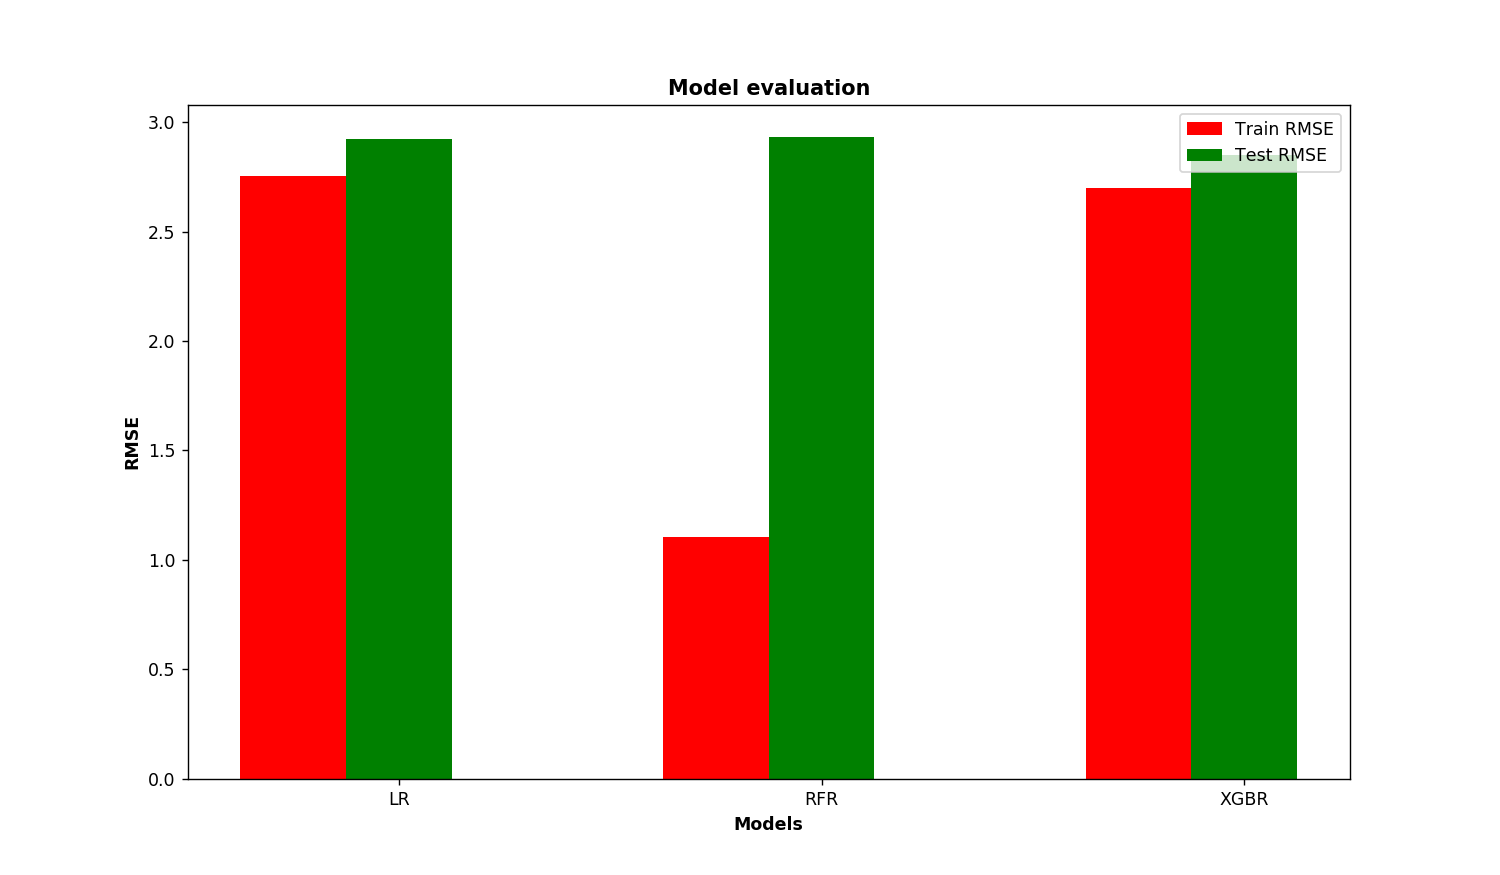

In [1005]:
plt.figure(figsize=(12,7))

# set width of bar
barWidth = 0.25
 
# Set position of bar on X axis
r1 = np.arange(len(Final_Table_RMSE.Train_Root_Mean_Square_Error.values.tolist()))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, Final_Table_RMSE.Train_Root_Mean_Square_Error.values.tolist(), color="red", width=barWidth, label='Train RMSE')
plt.bar(r2, Final_Table_RMSE.Test_Root_Mean_Square_Error.values.tolist(), color="green", width=barWidth, label='Test RMSE')
 
# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.ylabel('RMSE', fontweight='bold')
plt.title("Model evaluation", fontweight='bold')
plt.xticks([r + barWidth for r in range(len(Final_Table_RMSE.Train_Root_Mean_Square_Error.values.tolist()))], ["LR", "RFR", "XGBR"])
 
# Create legend & Show graphic
plt.legend(loc = "upper right")
plt.show()

# Assumptions:
1. Removed lines with error while loading text file data to dataframe.
2. The distance of the trip is straight line.
3. Assume that the coordinates are correct and lie within SF area.
4. Maximum allowed trip duration is 4 hours i.e. 240 mins
5. Maximum allowed speed in SF is 100 miles/hour
6. Circular rides are possible (same start longitude-latitude and end langitude-latitudes)
7. The goal of the segmentation process.

5. The minimum inter-cluster distance (while finding region from longitude and latitude) is 0.5 miles.